### Principles of Urban Informatics
### Final Examination - Fall 2016
### Achilles Edwin Alfred Saxby
### aes807

#### Motivation:

One of the things that make NYC so interesting to study is its diversity on many axes: 
- Ethnic, 
- Economic and
- Cultural. 

Neighborhoods tend to be segregated and clustered on most socioeconomic characteristics, however these characteristics do evolve in time. 

The goal is to identify NYC neighborhoods that are homogeneous by clustering their socioeconomic characteristics in 2000, and in 2010, and find the neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers (e.g. gentrification).

- All files have been downloaded and stored in the PUIData folder on my personal directory.
- Property of New York University - Center for Urban Science and Progress

### WarmUp

### Finding the number of businesses in 2010 and 2000. 
#### This information is available at the zipcode level.

In [196]:
import os
import ast
import json
import urllib
import urllib2
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pylab as plt
import pysal as psl

from sklearn.cluster import KMeans
from cStringIO import StringIO
from fiona.crs import from_epsg

%matplotlib inline

In [160]:
!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip

if os.path.isfile("zbp" + "00" + "totals.zip"):
    print ('File in current directory, moving it to PUIdata')
    os.system("mv " + "zbp" + "00" + "totals.zip " + os.getenv("PUIDATA"))
else:
    print ('File has not been moved yet - maybe not even downloaded')


if not os.path.isfile(os.getenv("PUIDATA") + "/" + "zbp" + "00" + "totals.zip"):
    print ("WARNING!!! something is wrong: the file zbp" + "00" + "totals.zip is not there!")
else:
    print ("zbp" + "00" + "totals.zip file is in PUIdata")

--2016-12-18 22:37:11--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

100%[======================================>] 628,434     1.83M/s   in 0.3s    

2016-12-18 22:37:12 (1.83 MB/s) - “zbp00totals.zip” saved [628434]

File in current directory, moving it to PUIdata
zbp00totals.zip file is in PUIdata


##### Stored in PUIData

In [161]:
!wget ftp://ftp.census.gov/econ2010\/CBP_CSV/zbp10\totals.zip

if os.path.isfile("zbp" + "10" + "totals.zip"):
    print ('File in current directory, moving it to PUIdata')
    os.system("mv " + "zbp" + "10" + "totals.zip " + os.getenv("PUIDATA"))
else:
    print ('File has not been moved yet - maybe not even downloaded')


if not os.path.isfile(os.getenv("PUIDATA") + "/" + "zbp" + "10" + "totals.zip"):
    print ("WARNING!!! something is wrong: the file zbp" + "10" + "totals.zip is not there!")
else:
    print ("zbp" + "10" + "totals.zip file is in PUIdata")

--2016-12-18 22:37:17--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => “zbp10totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-12-18 22:42:18--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
  (try: 2) => “zbp10totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /econ2010/CBP_CSV ... done.
==> SIZE zbp10totals.zip ... 797534
==> PASV ... done.    ==> RETR zbp10totals.zip ... done.
Length: 797534 (779K) (unauthoritative)

100%[======================================>] 797,534      473K/s   in 1.6s    

2016-12-18 22:42:20 (473 KB/s) - “zbp10totals.zip” saved [797534]

File in current directory, moving it to PUIdata
zbp10totals.zi

##### Stored in PUIData

In [3]:
PUIData_Path = "/home/cusp/aes807/PUIdata/"

##### Stored in PUIData
- Downloaded from Instructor's Notebooks.
- https://github.com/fedhere/PUI2016_fb55/blob/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson

In [4]:
zip_codes_shape = gpd.read_file(PUIData_Path + "NYC_zipcode_ploygons.geojson")
zip_codes_shape.head()

@id  BLDGpostalCode CTY_FIPS  \
0  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
1  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
2  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
3  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
4  http://nyc.pediacities.com/Resource/PostalCode...               0      081   

   OBJECTID          PO_NAME STATE ST_FIPS    Shape_Area    Shape_Leng  \
0         1  Jackson Heights    NY      36  2.016328e+07  20624.692317   
1         2        Glen Oaks    NY      36  2.260653e+07  23002.816039   
2         3    New Hyde Park    NY      36  6.269333e+06  15749.161511   
3         4        Bellerose    NY      36  4.941836e+07  35932.810639   
4         5    Fresh Meadows    NY      36  6.938587e+07  38693.565676   

  borough                                           geometry postalCode  
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...      11372  
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...      11004  
2  Queens  POLYGON ((-73.70098278625547 40.73889569923034...      11040  
3  Queens  POLYGON ((-73.72270447144122 40.75373371438336...      11426  
4  Queens  POLYGON ((-73.81088634744755 40.72717187575918...      11365

In [5]:
zip_codes_shape = zip_codes_shape.drop([ u'@id', u'BLDGpostalCode', u'PO_NAME', u'CTY_FIPS', 
                                        u'ST_FIPS', u'STATE', u'OBJECTID', u'borough', 
                                        u'Shape_Leng'], axis = 1)
zip_codes_shape = zip_codes_shape.rename(columns={'postalCode' : 'zip_code'})
zip_codes_shape['zip_code'] = pd.to_numeric(zip_codes_shape['zip_code'], errors = 'coerce')
zip_codes_shape.head()

Shape_Area                                           geometry  zip_code
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365

In [6]:
zip_codes_shape['zip_code'] = pd.to_numeric(zip_codes_shape['zip_code'])
zip_codes_shape['zip_code']

0      11372
1      11004
2      11040
3      11426
4      11365
5      11373
6      11001
7      11375
8      11427
9      11374
10     11366
11     11423
12     11428
13     11432
14     11379
15     11429
16     11435
17     11415
18     11418
19     11433
20     11451
21     11221
22     11421
23     11419
24     11434
25     11216
26     11416
27     11233
28     11436
29     11213
       ...  
232    10106
233    10158
234    10041
235    10120
236    10278
237    10155
238    10022
239    10043
240    10081
241    10096
242    10097
243    10196
244    10196
245    10275
246    10265
247    10045
248    10047
249    10047
250    10080
251    10203
252    10259
253    10260
254    10285
255    10286
256    11370
257    10065
258    10075
259    10069
260    10281
261    10282
Name: zip_code, dtype: int64

### Gathering a zipcode shapefile and merging the number of businesses with the zipcode shapfile.

In [7]:
year = ["00", "10"]

for i in year:
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" + "zbp" + i + "totals.zip")
    temp = pd.read_csv(zf.open('zbp'+ i +'totals.zip'.replace('.zip','.txt')))
    temp.columns = map(str.lower, temp.columns)
    temp = temp[['zip', 'est']]
    year = dt.datetime.strptime(str(i), '%y').year
    temp.rename(columns={'est': str(year), 'zip':'zip_code'}, inplace=True)
    zip_codes_shape = zip_codes_shape.merge(temp, on = 'zip_code', how = 'inner')
    print("Year "+str(i)+'\n')
    print(zip_codes_shape.head())
    print('\n')

zip_codes_shape.head()

Year 00

     Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  
0  1409  
1   189  
2  1350  
3   213  
4   553  


Year 10

     Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634

Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  2010  
0  1409  1629  
1   189   229  
2  1350  1494  
3   213   248  
4   553   643

##### This table shows the spatial join of the Business Data for the Years 2010 and 2000 joined with the ZipCodes of their respective establishments and areas of the same.

In [8]:
len(zip_codes_shape['zip_code'].unique())

237

### Finding the density of businesses by dividing the number of businesses by the area of the zipcode.

In [9]:
zip_codes_shape.geometry.area == zip_codes_shape["Shape_Area"]

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
220    False
221    False
222    False
223    False
224    False
225    False
226    False
227    False
228    False
229    False
230    False
231    False
232    False
233    False
234    False
235    False
236    False
237    False
238    False
239    False
240    False
241    False
242    False
243    False
244    False
245    False
246    False
247    False
248    False
249    False
dtype: bool

- As we can observe above, the Polygon Calculated Area is not equal to any part of the Shape_Area column given.
- We can take the Polygon area as a better variable to calculate the densities, since it is more reliable than the Shape_Area since we have no idea from where that area has been calculated, we can safely use the area that we calculate.

In [10]:
zip_codes_shape["Calculated_Area"] = zip_codes_shape.geometry.area
zip_codes_shape.head()

Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  2010  Calculated_Area  
0  1409  1629         0.000200  
1   189   229         0.000224  
2  1350  1494         0.000062  
3   213   248         0.000489  
4   553   643         0.000688

In [11]:
zip_codes_shape["Density_2000"] = zip_codes_shape["2000"] / zip_codes_shape["Calculated_Area"]
zip_codes_shape["Density_2010"] = zip_codes_shape["2010"] / zip_codes_shape["Calculated_Area"]
zip_codes_shape.head()

Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  2010  Calculated_Area  Density_2000  Density_2010  
0  1409  1629         0.000200  7.045865e+06  8.146000e+06  
1   189   229         0.000224  8.433038e+05  1.021781e+06  
2  1350  1494         0.000062  2.176227e+07  2.408358e+07  
3   213   248         0.000489  4.354292e+05  5.069786e+05  
4   553   643         0.000688  8.041634e+05  9.350399e+05

##### The Densities Shown here, has been calculated by dividing (the number of establishments in a zipcode) by (the area of that zipcode), since the area is on the higer range. The observations can be seen as minute decimal statistics. 

In [12]:
zip_codes_shape["Density_2000"] = zip_codes_shape["Density_2000"] / 10000
zip_codes_shape["Density_2010"] = zip_codes_shape["Density_2010"] / 10000
zip_codes_shape.head()

Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  2010  Calculated_Area  Density_2000  Density_2010  
0  1409  1629         0.000200    704.586533    814.600044  
1   189   229         0.000224     84.330384    102.178084  
2  1350  1494         0.000062   2176.227439   2408.358366  
3   213   248         0.000489     43.542923     50.697864  
4   553   643         0.000688     80.416343     93.503994

##### To get the densities in a "plottable" , we multiply each density by 10000000 so as to give the ease of plotting the variables.

### The density in a Choropleth (a heatmap version of a geographical map where each zipcode (census tract later) is a different color based on the value of the feature you are mapping) for 2000 and 2010.

##### Laboratory Code - Homework_9 - SRK325 - Laboratory Component 
- The plots in this section have been plotted using the code from the links given below - StackOverFlow and Instructor Codes.
- http://stackoverflow.com/questions/31755886/choropleth-map-from-geopandas-geodatafame
- https://github.com/fedhere/PUI2016_fb55/blob/master/Lab9_SRK325/GeospatialAnalysis_CitiBike.ipynb

In [13]:
Density_2000 = psl.Quantiles(zip_codes_shape["Density_2000"], k=5)
Density_2000

                   Quantiles                    
 
  Lower                Upper               Count
             x[i] <=     80.380               50
    80.380 < x[i] <=    181.852               50
   181.852 < x[i] <=    360.094               50
   360.094 < x[i] <=   5785.196               50
  5785.196 < x[i] <= 162907.869               50

##### Quartile Segregation - Densities for the Year 2000
- The densities, due to the widespread range and large numbers have been seperated into Quartiles.
- This segregates based on the distribution and not the values of the numbers itself, hence it segregates nearly equally.

In [14]:
Density_2010 = psl.Quantiles(zip_codes_shape["Density_2010"], k=5)
Density_2010

                   Quantiles                    
 
  Lower                Upper               Count
             x[i] <=     95.246               50
    95.246 < x[i] <=    229.166               50
   229.166 < x[i] <=    443.306               50
   443.306 < x[i] <=   5090.075               50
  5090.075 < x[i] <= 133062.153               50

##### Quartile Segregation - Densities for the Year 2010
- The densities, due to the widespread range and large numbers have been seperated into Quartiles.
- This segregates based on the distribution and not the values of the numbers itself, hence it segregates nearly equally.

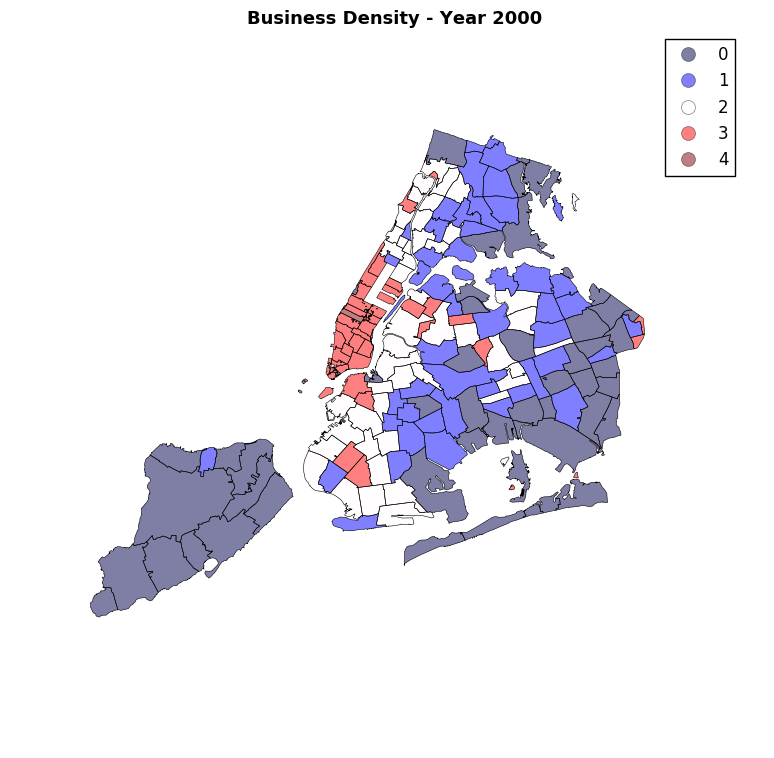

In [15]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

zip_codes_shape.assign(cl=Density_2000.yb).plot(column='cl', categorical=True, 
        k=5, cmap='seismic',ax=ax, linewidth=0.4, edgecolor='black', legend=True,)

ax.set_axis_off()
ax.set_title("Business Density - Year 2000", fontweight = 'bold', fontsize = '13')

#### Figure-1: Observed here is the choropleth/heat map depicting the business densities that existed during the year 2000.

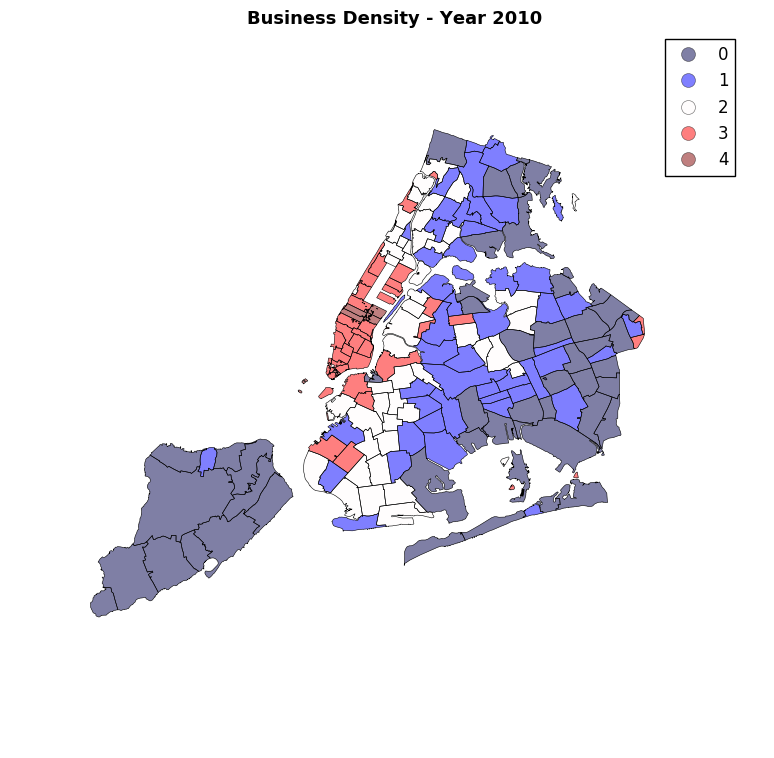

In [16]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

zip_codes_shape.assign(cl=Density_2010.yb).plot(column='cl', categorical=True, 
        k=5, cmap='seismic',ax=ax, linewidth=0.4, edgecolor='black', legend=True)

ax.set_axis_off()
ax.set_title("Business Density - Year 2010", fontweight = 'bold', fontsize = '13')

#### Figure-2: Observed here is the choropleth/heat map depicting the business densities that existed during the year 2010.

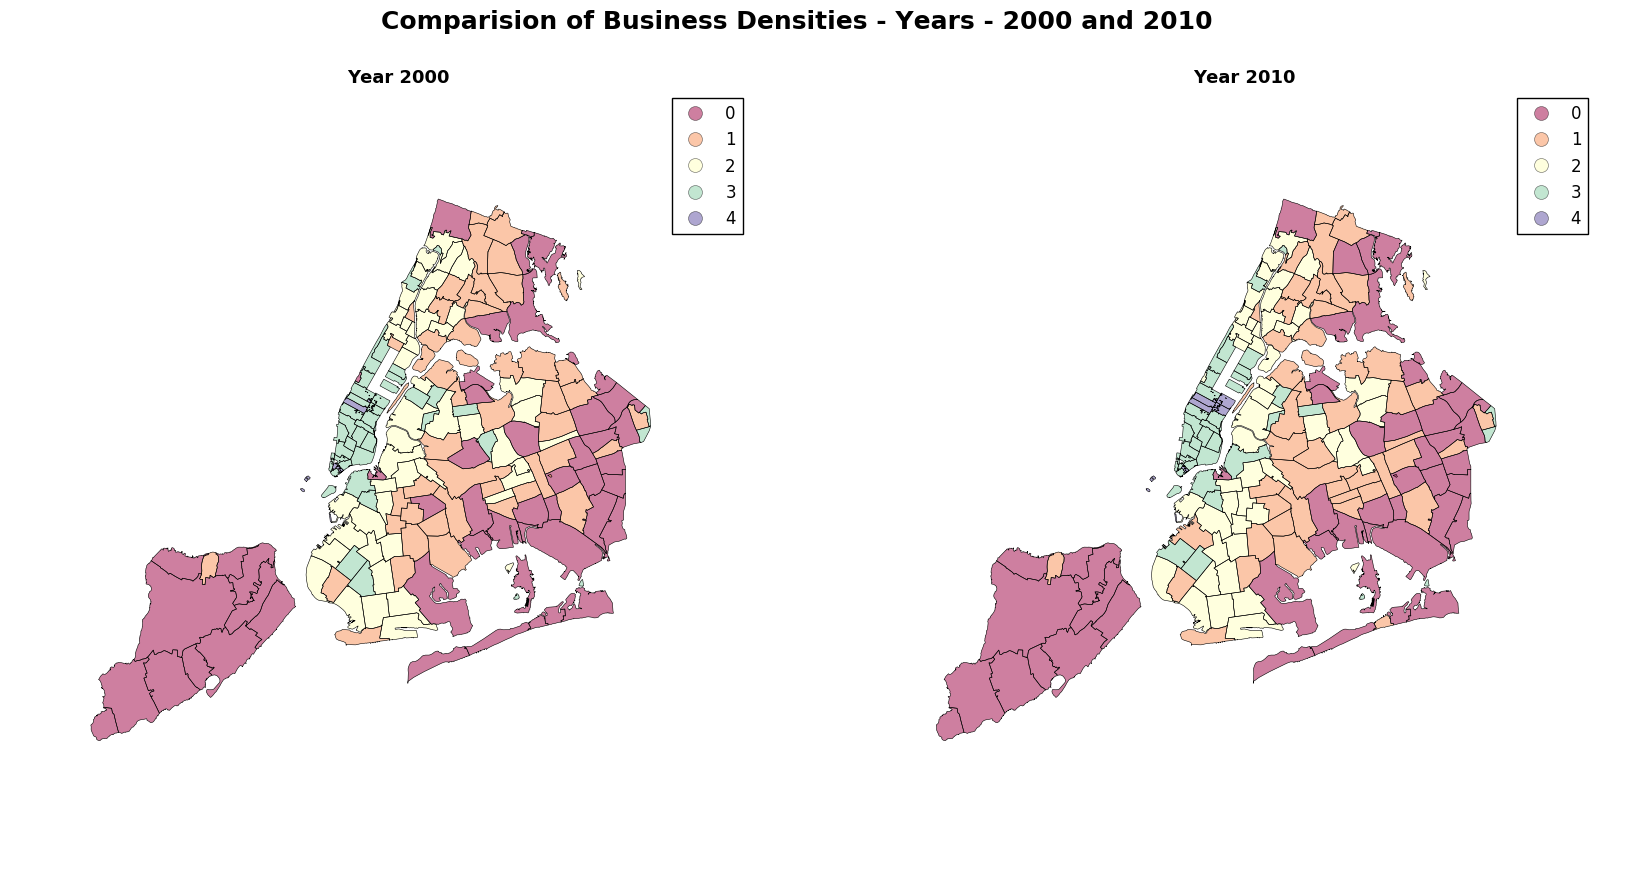

In [17]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

zip_codes_shape.assign(cl=Density_2000.yb).plot(column='cl', categorical=True, 
        k=5, cmap='Spectral',ax=ax1, linewidth=0.4, edgecolor='black', legend=True)

ax1.set_axis_off()
ax1.set_title("Year 2000", fontweight = 'bold', fontsize = '13')


zip_codes_shape.assign(cl=Density_2010.yb).plot(column='cl', categorical=True, 
        k=5, cmap='Spectral',ax=ax2, linewidth=0.4, edgecolor='black', legend=True)

ax2.set_axis_off()
ax2.set_title("Year 2010", fontweight = 'bold', fontsize = '13')

plt.suptitle("Comparision of Business Densities - Years - 2000 and 2010", 
             fontweight = 'bold', fontsize = 18)

#### Figure-3: This figure represents the comparision images for the business densities, during the years 2000 and 2010.
- It can be seen here that Midtown has more density in 2010 than it had in 2000.
- Also, Bronx can be observed to have a higher density meaning more establishments in 2010 than in 2000.

### OPTIONAL:
#### The difference in business density between 2000 and 2010 in a map.

In [18]:
zip_codes_shape["Density_Difference"] = Density_2000.yb == Density_2010.yb
zip_codes_shape.head()

Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  2010  Calculated_Area  Density_2000  Density_2010 Density_Difference  
0  1409  1629         0.000200    704.586533    814.600044               True  
1   189   229         0.000224     84.330384    102.178084               True  
2  1350  1494         0.000062   2176.227439   2408.358366               True  
3   213   248         0.000489     43.542923     50.697864               True  
4   553   643         0.000688     80.416343     93.503994              False

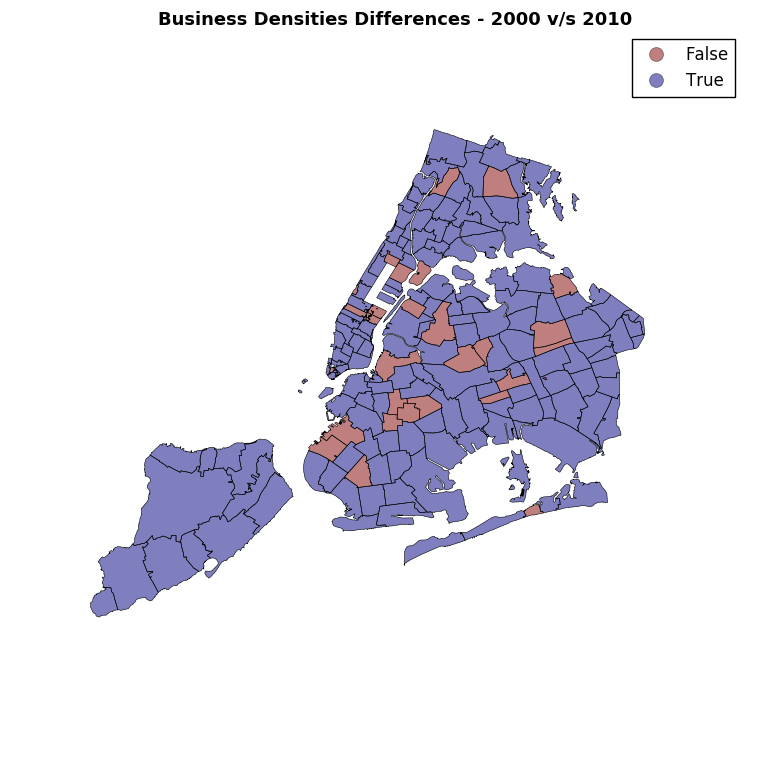

In [19]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

zip_codes_shape.plot(column="Density_Difference", categorical=True, k=5, 
                     cmap='jet_r',ax=ax, linewidth=0.4, 
                     edgecolor='black', legend=True)

ax.set_axis_off()
ax.set_title("Business Densities Differences - 2000 v/s 2010", 
             fontweight = 'bold', fontsize = '13')

#### Figure-4: It can be observed in this map, that there exists some differences between the Business Establishments/Densities from 2000 to 2010.
- There are more establishments in 2010 than there were in 2000.
- It can be seen clearly here now that Midtown has more density in 2010 than it had in 2000.
- It can also be clearly observed how Bronx, Brooklyn both have more establishments in 2010 than in 2000.
- Using this map to check and see if there is a difference helps in making sure that the analysis is going the intended way.

### More Serious Stuff

#### Collecting the census data from the 2010 and 2000 census and extracting the estimate (mean or median) age, population, and diversity of each census tract for all 5 NYC boroughs. 
- The diversity (or lack thereof) can be measured by the fraction of white population.

#### Downloading Alternatively with an SQL query from public data in cartoDB.
- Function provided for that purpose in the instructors notes: https://github.com/fedhere/PUI2016_final/blob/master/PUI2016_DATA.ipynb

In [20]:
SQL_SOURCE = 'https://fb55.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """queries data from CartoDB SQL database
    Arguments:
    query: a string like 
            SELECT colum_name_1, column_name_2 FROM database_name
    format: the file format (e.g. CSV, GeoJson)
    source: the sql database url link
    Return:
        database as a string to be read in with the appropriate function
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

### Selecting the Tables needed, to download from.
#### Using the code below, again found in the instructor's notes, downloading the respective tables as a whole.
- The MetaData has been observed for this code, and the resuting columns have been looked at for the same.
- The MetaData can be found in:
    - http://cosmo.nyu.edu/~fb55/PUI2016/data/
    - http://www.christinafriedle.com/uploads/1/8/4/7/1847486/lab1_mappingcensusdata.doc

#### Collecting the income data by census tract using SQL queries for the years 2010 and 2000 at the census tract level.

#### Query and Download for the Census_Tract File

In [21]:
query = "SELECT * FROM table_2010_census_tracts"

In [22]:
datastream = queryCartoDB(query, format='GeoJSON')
datageo = json.loads(datastream.read())
ct = gpd.GeoDataFrame.from_features(datageo['features'])
ct.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  
0                              Flatbush  4015  1110945.63082  4305.94762341  
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209  
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952  
3                            Whitestone  4103  11557974.9909  17092.0365078  
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859

In [23]:
countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

In [24]:
ct['allcodes'] = list(zip(ct.boro_name, ct.ct_2010))
ct['geo_id']  = ct[['allcodes']].applymap(lambda x: 
                            ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

In [25]:
ct.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

             allcodes                geo_id  
0  (Brooklyn, 050804)  1400000US36047050804  
1  (Brooklyn, 027500)  1400000US36047027500  
2     (Bronx, 009200)  1400000US36005009200  
3    (Queens, 099100)  1400000US36081099100  
4    (Queens, 000100)  1400000US36081000100

#### Query, Dowload and Wrangling for the Census 2000: DEC_00_SF1_DP1

In [26]:
query_00 = "SELECT geo_id, hc01_vc01, hc02_vc29, hc01_vc18 FROM dec_00_sf1_dp1"

In [27]:
datastream = queryCartoDB(query_00, format='JSON')
datageo = json.loads(datastream.read())
census_2000 = gpd.GeoDataFrame.from_dict(datageo['rows'])
census_2000.head()

geo_id hc01_vc01 hc01_vc18 hc02_vc29
0  1400000US36047054300         0       0.0          
1  1400000US36081121100         0       0.0          
2  1400000US36005003700       478      22.0      18.4
3  1400000US36005004900       246      30.0      20.7
4  1400000US36005005800         5      23.5       0.0

In [28]:
census_2000 = census_2000.rename(columns = {"hc01_vc01":"Total_Pop_Number",\
                                           "hc01_vc18":"Median_Age",\
                                           "hc02_vc29":"White_Pop_Percent"})
census_2000.head()

geo_id Total_Pop_Number Median_Age White_Pop_Percent
0  1400000US36047054300                0        0.0                  
1  1400000US36081121100                0        0.0                  
2  1400000US36005003700              478       22.0              18.4
3  1400000US36005004900              246       30.0              20.7
4  1400000US36005005800                5       23.5               0.0

#### Query, Dowload and Wrangling for the Census 2010: DEC_10_SF1_SF1DP1

In [29]:
query_10 = "SELECT geo_id, hd01_s001, hd01_s020, hd02_s078 FROM dec_10_sf1_sf1dp1"

In [30]:
datastream = queryCartoDB(query_10, format='JSON')
datageo = json.loads(datastream.read())
census_2010 = gpd.GeoDataFrame.from_dict(datageo['rows'])
census_2010.head()

geo_id hd01_s001 hd01_s020 hd02_s078
0  1400000US36081038301         0         0          
1  1400000US36005002400         4        38        50
2  1400000US36059990200         0         0          
3  1400000US36059990400         0         0          
4  1400000US36007012900      1532      59.8      98.2

In [31]:
census_2010 = census_2010.rename(columns = {"hd01_s001":"Total_Pop_Number",\
                                           "hd01_s020":"Median_Age",\
                                           "hd02_s078":"White_Pop_Percent"})
census_2010.head()

geo_id Total_Pop_Number Median_Age White_Pop_Percent
0  1400000US36081038301                0          0                  
1  1400000US36005002400                4         38                50
2  1400000US36059990200                0          0                  
3  1400000US36059990400                0          0                  
4  1400000US36007012900             1532       59.8              98.2

#### Query, Dowload and Wrangling for the Income Census 2000: DEC_00_SF3_DP3_with_ann.csv

In [32]:
query_ic_00 = "SELECT geo_id, hc01_vc64 FROM dec_00_sf3_dp3_with_ann"

In [33]:
datastream = queryCartoDB(query_ic_00, format='JSON')
datageo = json.loads(datastream.read())
income_census_2000 = gpd.GeoDataFrame.from_dict(datageo['rows'])
income_census_2000.head()

geo_id  hc01_vc64
0  1400000US36089991900          0
1  1400000US36001013703      68929
2  1400000US36005000200      42539
3  1400000US36005002400          0
4  1400000US36029001301          0

In [34]:
income_census_2000 = income_census_2000.rename(columns = {"hc01_vc64":"Median_HH_Income"})
income_census_2000.head()

geo_id  Median_HH_Income
0  1400000US36089991900                 0
1  1400000US36001013703             68929
2  1400000US36005000200             42539
3  1400000US36005002400                 0
4  1400000US36029001301                 0

#### Query, Dowload and Wrangling for the Income Census 2010: ACS_10_5YR_S1901_with_ann.csv

In [35]:
query_ic_10 = "SELECT geo_id, hc01_est_vc13 FROM acs_10_5yr_s1901_with_ann"

In [36]:
datastream = queryCartoDB(query_ic_10, format='JSON')
datageo = json.loads(datastream.read())
income_census_2010 = gpd.GeoDataFrame.from_dict(datageo['rows'])
income_census_2010.head()

geo_id hc01_est_vc13
0  1400000US36001000100         32333
1  1400000US36001000200         25354
2  1400000US36001000300         30932
3  1400000US36001000401         60909
4  1400000US36001000403         52807

In [37]:
income_census_2010 = income_census_2010.rename(columns = {"hc01_est_vc13":"Median_HH_Income"})
income_census_2010.head()

geo_id Median_HH_Income
0  1400000US36001000100            32333
1  1400000US36001000200            25354
2  1400000US36001000300            30932
3  1400000US36001000401            60909
4  1400000US36001000403            52807

#### Merging the datasets for each year and showing tables containing the relevant data: (from Census Tract File)
- Geometry
- geo_id

#### Figuring out, and working with the Merging of the Census Tract files with the Census and Income_Census files for the years:
- 2000
    - Total Population Number
    - Median Age
    - White Population Percentage
    - Median Household Income
- 2010
    - Total Population Number
    - Median Age
    - White Population Percentage
    - Median Household Income

In [38]:
ct.shape

(2166, 15)

In [39]:
census_2000.shape

(4907, 4)

In [40]:
census_2010.shape

(4919, 4)

In [41]:
income_census_2000.shape

(4907, 2)

In [42]:
income_census_2010.shape

(4919, 2)

In [222]:
merged_2k = pd.merge(ct, census_2000, on = 'geo_id', how = 'left')
merged_2k.shape

(2166, 18)

In [223]:
merged_2000 = pd.merge(merged_2k, income_census_2000, on = 'geo_id', how = 'left')
print (merged_2000.shape)
merged_2000.head()

(2166, 19)


boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

             allcodes                geo_id Total_Pop_Number Median_Age  \
0  (Brooklyn, 050804)  1400000US36047050804              NaN        NaN   
1  (Brooklyn, 027500)  1400000US36047027500             4171       33.9   
2     (Bronx, 009200)  1400000US36005009200             4877       31.7   
3    (Queens, 099100)  1400000US36081099100             6659       47.1   
4    (Queens, 000100)  1400000US36081000100             1370       41.3   

  White_Pop_Percent  Median_HH_Income  
0               NaN               NaN  
1               1.5           30241.0  
2              30.1           36589.0  
3              87.7           62341.0  
4              55.4           85898.0

In [224]:
merged_2000 = merged_2000.drop(['boro_code', 'boro_ct_2010', 'boro_name', 'cartodb_id',
                                'cdeligibil', 'ct_2010', 'ctlabel', 'ntacode', 'ntaname', 
                                'puma', 'shape_area', 'shape_leng', 'allcodes'], axis = 1)
merged_2000.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

  Total_Pop_Number Median_Age White_Pop_Percent  Median_HH_Income  
0              NaN        NaN               NaN               NaN  
1             4171       33.9               1.5           30241.0  
2             4877       31.7              30.1           36589.0  
3             6659       47.1              87.7           62341.0  
4             1370       41.3              55.4           85898.0

In [225]:
merged_2k10 = pd.merge(ct, census_2010, on = 'geo_id', how = 'left')
merged_2k10.shape

(2166, 18)

In [226]:
merged_2010 = pd.merge(merged_2k10, income_census_2010, on = 'geo_id', how = 'left')
print (merged_2010.shape)
merged_2010.head()

(2166, 19)


boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

             allcodes                geo_id Total_Pop_Number Median_Age  \
0  (Brooklyn, 050804)  1400000US36047050804             6250       32.7   
1  (Brooklyn, 027500)  1400000US36047027500             4180       35.6   
2     (Bronx, 009200)  1400000US36005009200             5017       33.3   
3    (Queens, 099100)  1400000US36081099100             6507       51.1   
4    (Queens, 000100)  1400000US36081000100             4949       32.4   

  White_Pop_Percent Median_HH_Income  
0              15.5            40188  
1               9.1            52958  
2              29.5            45625  
3              85.5            84350  
4              63.5           117750

In [227]:
merged_2010 = merged_2010.drop(['boro_code', 'boro_ct_2010', 'boro_name', 'cartodb_id',
                                'cdeligibil', 'ct_2010', 'ctlabel', 'ntacode', 'ntaname', 
                                'puma', 'shape_area', 'shape_leng', 'allcodes'], axis = 1)
merged_2010.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

  Total_Pop_Number Median_Age White_Pop_Percent Median_HH_Income  
0             6250       32.7              15.5            40188  
1             4180       35.6               9.1            52958  
2             5017       33.3              29.5            45625  
3             6507       51.1              85.5            84350  
4             4949       32.4              63.5           117750

### Main DataSets to work with now after Downloading, Wrangling and Dropping Trivial Features:

#### Data for 2000

In [228]:
print (merged_2000.shape)
merged_2000.head()

(2166, 6)


geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

  Total_Pop_Number Median_Age White_Pop_Percent  Median_HH_Income  
0              NaN        NaN               NaN               NaN  
1             4171       33.9               1.5           30241.0  
2             4877       31.7              30.1           36589.0  
3             6659       47.1              87.7           62341.0  
4             1370       41.3              55.4           85898.0

#### Data for 2010

In [229]:
print (merged_2010.shape)
merged_2010.head()

(2166, 6)


geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

  Total_Pop_Number Median_Age White_Pop_Percent Median_HH_Income  
0             6250       32.7              15.5            40188  
1             4180       35.6               9.1            52958  
2             5017       33.3              29.5            45625  
3             6507       51.1              85.5            84350  
4             4949       32.4              63.5           117750

### Merging the GeoDataFrame with the census tracts shapefile - see above.

#### Converting everything to float, so that the Quantiles can be calculated easily.

In [230]:
print (merged_2000.dtypes)

geometry              object
geo_id                object
Total_Pop_Number      object
Median_Age            object
White_Pop_Percent     object
Median_HH_Income     float64
dtype: object


In [231]:
print (merged_2010.dtypes)

geometry             object
geo_id               object
Total_Pop_Number     object
Median_Age           object
White_Pop_Percent    object
Median_HH_Income     object
dtype: object


In [232]:
merged_2000.Total_Pop_Number = merged_2000.Total_Pop_Number.astype(float)
merged_2000.Median_Age = merged_2000.Median_Age.astype(float)
merged_2000['White_Pop_Percent'] = pd.to_numeric(merged_2000['White_Pop_Percent'])

In [233]:
print (merged_2000.dtypes)

geometry              object
geo_id                object
Total_Pop_Number     float64
Median_Age           float64
White_Pop_Percent    float64
Median_HH_Income     float64
dtype: object


In [234]:
merged_2010.Total_Pop_Number = merged_2010.Total_Pop_Number.astype(float)
merged_2010.Median_Age = merged_2010.Median_Age.astype(float)
merged_2010['White_Pop_Percent'] = pd.to_numeric(merged_2010['White_Pop_Percent'])
merged_2010['Median_HH_Income'] = pd.to_numeric(merged_2010['Median_HH_Income'], errors='coerce')

In [235]:
print (merged_2010.dtypes)

geometry              object
geo_id                object
Total_Pop_Number     float64
Median_Age           float64
White_Pop_Percent    float64
Median_HH_Income     float64
dtype: object


#### Plotting the histogram for the features merged, wrangled and collected.

#### Data for the Year 2000

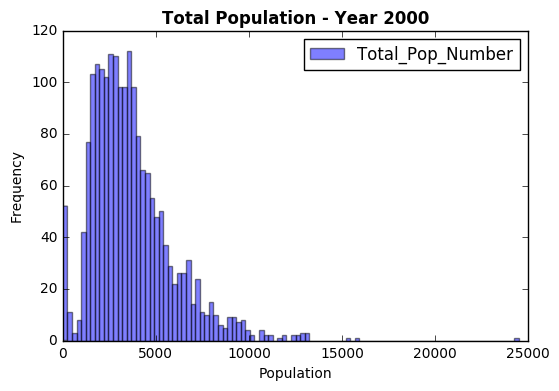

In [57]:
merged_2000.Total_Pop_Number.plot.hist(alpha = 0.5, bins = 100)
plt.xlabel('Population')
plt.title('Total Population - Year 2000', fontweight = 'bold')
plt.legend()

#### Figure-5:

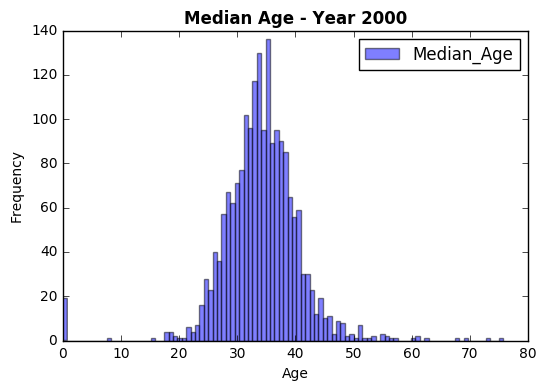

In [58]:
merged_2000.Median_Age.plot.hist(alpha = 0.5, bins = 100)
plt.xlabel('Age')
plt.title('Median Age - Year 2000', fontweight = 'bold')
plt.legend()

#### Figure-6:

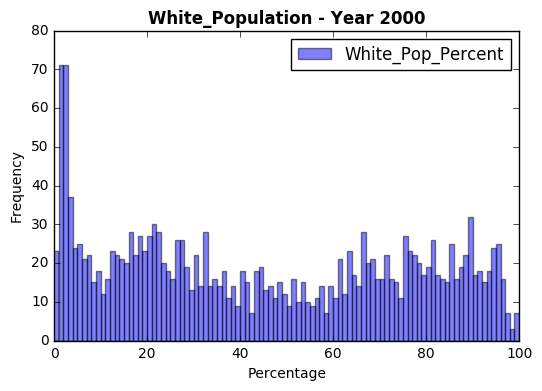

In [59]:
merged_2000.White_Pop_Percent.plot.hist(alpha = 0.5, bins = 100)
plt.xlabel('Percentage')
plt.title('White_Population - Year 2000', fontweight = 'bold')
plt.legend()

#### Figure-7:

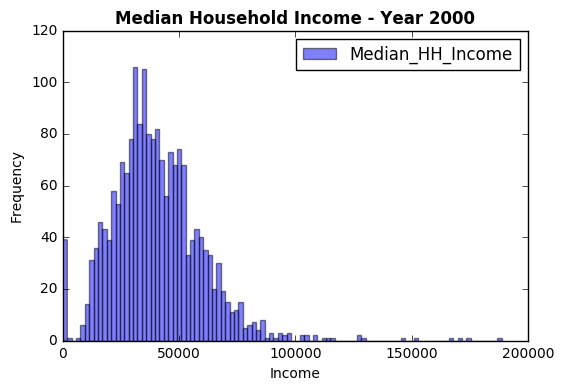

In [60]:
merged_2000.Median_HH_Income.plot.hist(alpha = 0.5, bins = 100)
plt.xlabel('Income')
plt.title('Median Household Income - Year 2000', fontweight = 'bold')
plt.legend()

#### Figure-8:

#### Data for the Year 2010

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/tools/plotting.py:968: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


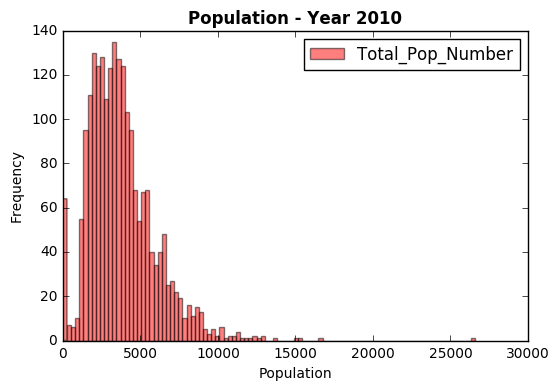

In [61]:
merged_2010.Total_Pop_Number.plot.hist(alpha = 0.5, bins = 100, colors = 'red')
plt.xlabel('Population')
plt.title('Population - Year 2010', fontweight = 'bold')
plt.legend()

#### Figure-9:

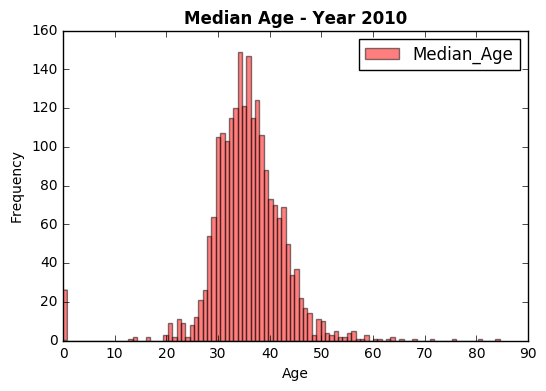

In [62]:
merged_2010.Median_Age.plot.hist(alpha = 0.5, bins = 100, colors = 'red')
plt.xlabel('Age')
plt.title('Median Age - Year 2010', fontweight = 'bold')
plt.legend()

#### Figure-10:

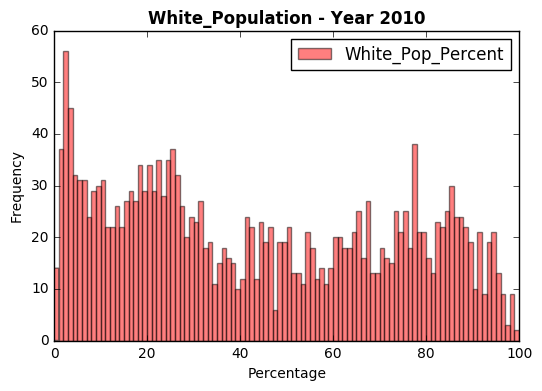

In [63]:
merged_2010.White_Pop_Percent.plot.hist(alpha = 0.5, bins = 100, colors = 'red')
plt.xlabel('Percentage')
plt.title('White_Population - Year 2010', fontweight = 'bold')
plt.legend()

#### Figure-11:

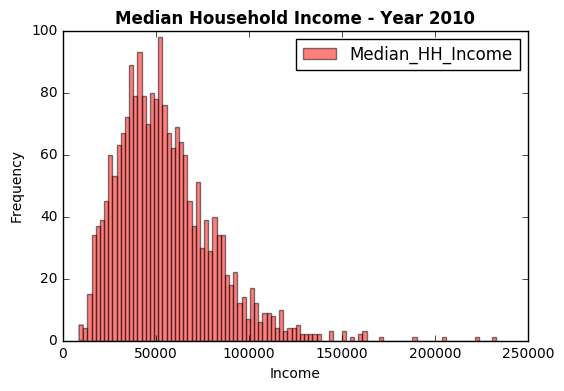

In [64]:
merged_2010.Median_HH_Income.plot.hist(alpha = 0.5, bins = 100, colors = 'red')
plt.xlabel('Income')
plt.title('Median Household Income - Year 2010', fontweight = 'bold')
plt.legend()

#### Figure-12:

#### Defining a function for creating Quantiles to plot the Choropleth easier.

In [236]:
def quantiles_function(dataframe, columns_name, a):
    '''
    This function creates quantiles for different factors in
    the DataFrame.
    
    The parameters are defined below-
    
    dataframe: The DataFrame that is being used
    columns_name: The Factors in that DataFrame
    a: The number of Quantiles
    '''
    quantiles = psl.Quantiles(dataframe[columns_name], k = a)
    return quantiles

#### Merged Dataset for 2000

In [237]:
qm2000Pop = quantiles_function(merged_2000, 'Total_Pop_Number', 5)
qm2000Pop

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <= 2044.000               867
2044.000 < x[i] <= 3033.000               433
3033.000 < x[i] <= 4116.000               433
4116.000 < x[i] <= 6566.000               433
6566.000 < x[i] <=      nan                 0

In [238]:
qm2000Age = quantiles_function(merged_2000, 'Median_Age', 5)
qm2000Age

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 30.200               868
30.200 < x[i] <= 33.500               435
33.500 < x[i] <= 36.400               430
36.400 < x[i] <= 40.800               433
40.800 < x[i] <=    nan                 0

In [239]:
qm2000White = quantiles_function(merged_2000, 'White_Pop_Percent', 5)
qm2000White

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 15.700               867
15.700 < x[i] <= 35.600               434
35.600 < x[i] <= 66.600               431
66.600 < x[i] <= 89.000               434
89.000 < x[i] <=    nan                 0

In [240]:
qm2000Income = quantiles_function(merged_2000, 'Median_HH_Income', 5)
qm2000Income

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <= 26343.000               867
26343.000 < x[i] <= 35703.000               433
35703.000 < x[i] <= 46610.000               433
46610.000 < x[i] <= 63333.000               433
63333.000 < x[i] <=       nan                 0

#### Merged Dataset for 2010

In [241]:
qm2010Pop = quantiles_function(merged_2010, 'Total_Pop_Number', 5)
qm2010Pop

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=  2047.000               434
 2047.000 < x[i] <=  2976.000               433
 2976.000 < x[i] <=  3893.000               433
 3893.000 < x[i] <=  5307.000               433
 5307.000 < x[i] <= 26588.000               433

In [242]:
qm2010Age = quantiles_function(merged_2010, 'Median_Age', 5)
qm2010Age

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 31.000               434
31.000 < x[i] <= 34.100               434
34.100 < x[i] <= 36.900               438
36.900 < x[i] <= 40.600               430
40.600 < x[i] <= 84.500               430

In [243]:
qm2010White = quantiles_function(merged_2010, 'White_Pop_Percent', 5)
qm2010White

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 14.200               869
14.200 < x[i] <= 28.500               431
28.500 < x[i] <= 53.300               434
53.300 < x[i] <= 77.000               432
77.000 < x[i] <=    nan                 0

In [244]:
qm2010Income = quantiles_function(merged_2010, 'Median_HH_Income', 5)
qm2010Income

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <= 33705.000               867
33705.000 < x[i] <= 45594.000               433
45594.000 < x[i] <= 57899.000               433
57899.000 < x[i] <= 76500.000               433
76500.000 < x[i] <=       nan                 0

#### Defining a function to create the choropleth based on the quantiles we have found and defined already.
#### Displaying each of the features as a choropleth for both 2010 and 2000.

In [77]:
def choropleth_function (dataframe_1, dataframe_2, quantile_1, quantile_2, name):
    '''
    This function creates a choropleth graph for 
    different factors to be compared with each 
    other in different DataFrames.
    
    The parameters are defined below-
    
    dataframe_1: The 1st DataFrame that is being used
    dataframe_2: The 2nd DataFrame that is being used
    quantile_1: The 1st Quantile that is being looked into
    quantile_2: The 2nd Quantile that is being looked into
    name: Naming the Plot - the Title
    '''
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    dataframe_1.assign(cl=quantile_1.yb).plot(column='cl', categorical=True, 
                                              k=5, cmap='Spectral',ax=ax1, 
                                              linewidth=0.4, edgecolor='black', legend=True)
    
    ax1.set_axis_off()
    ax1.set_title("Year 2000", fontweight = 'bold', fontsize = '13')
    
    dataframe_2.assign(cl=quantile_2.yb).plot(column='cl', categorical=True, 
                                              k=5, cmap='Spectral',ax=ax2, 
                                              linewidth=0.4, edgecolor='black', legend=True)
    
    ax2.set_axis_off()
    ax2.set_title("Year 2010", fontweight = 'bold', fontsize = '13')
    
    plt.suptitle(name + ' ' + "Comparision for Years - 2000 and 2010", 
                 fontweight = 'bold', fontsize = 18)

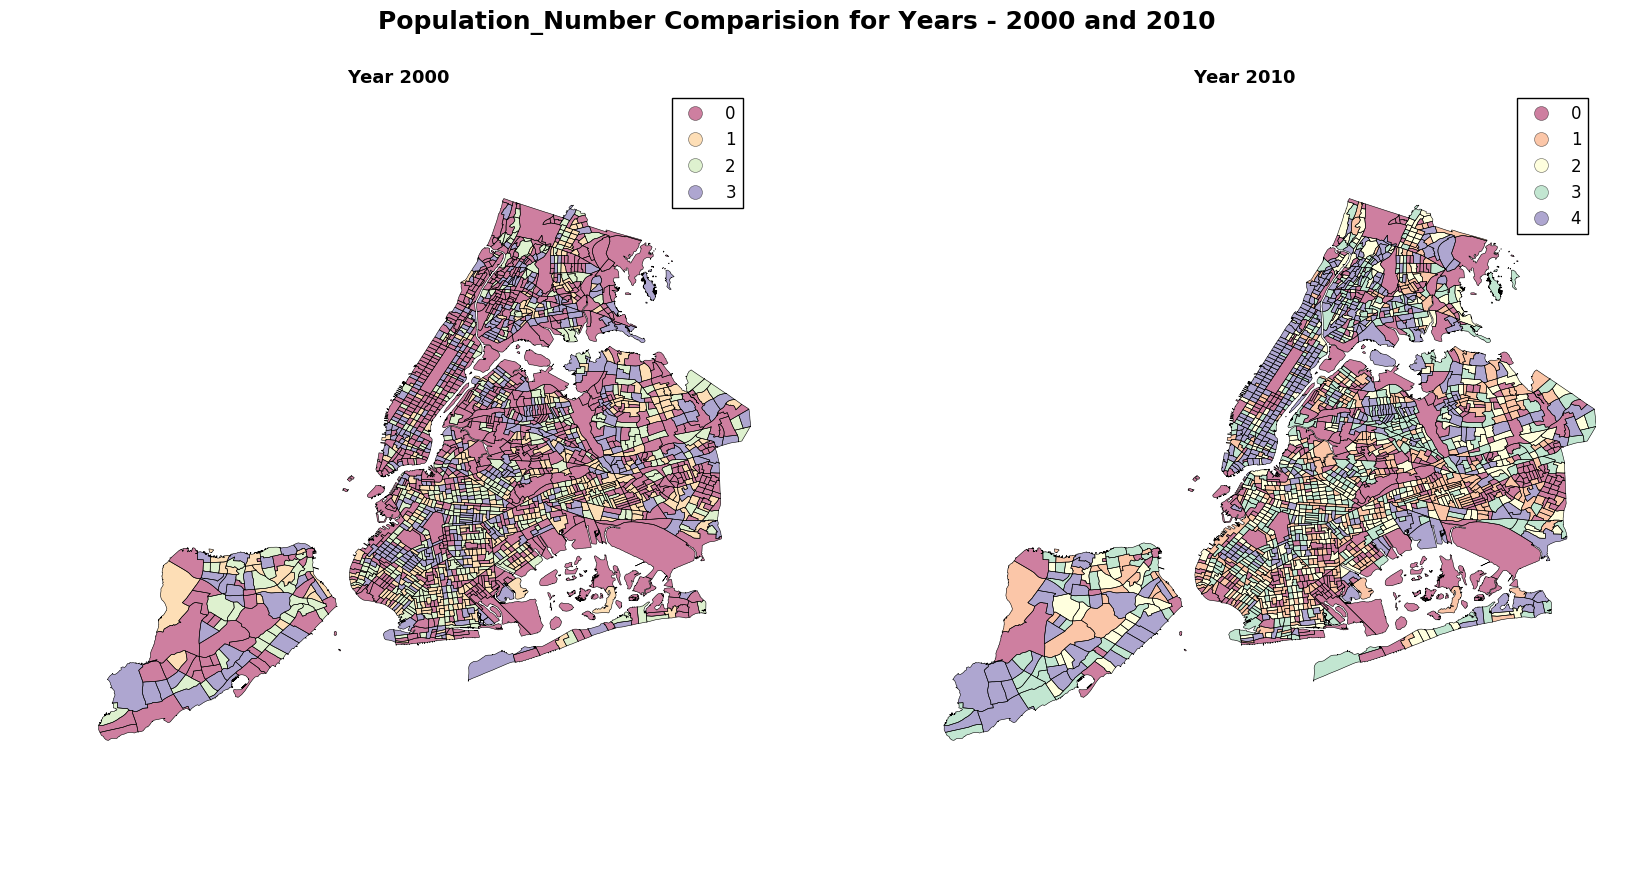

In [78]:
choropleth_function(merged_2000, merged_2010, qm2000Pop, qm2010Pop, 'Population_Number')

#### Figure-13: This figure represents the Population Comparision between the years 2000 (left) and 2010 (right)

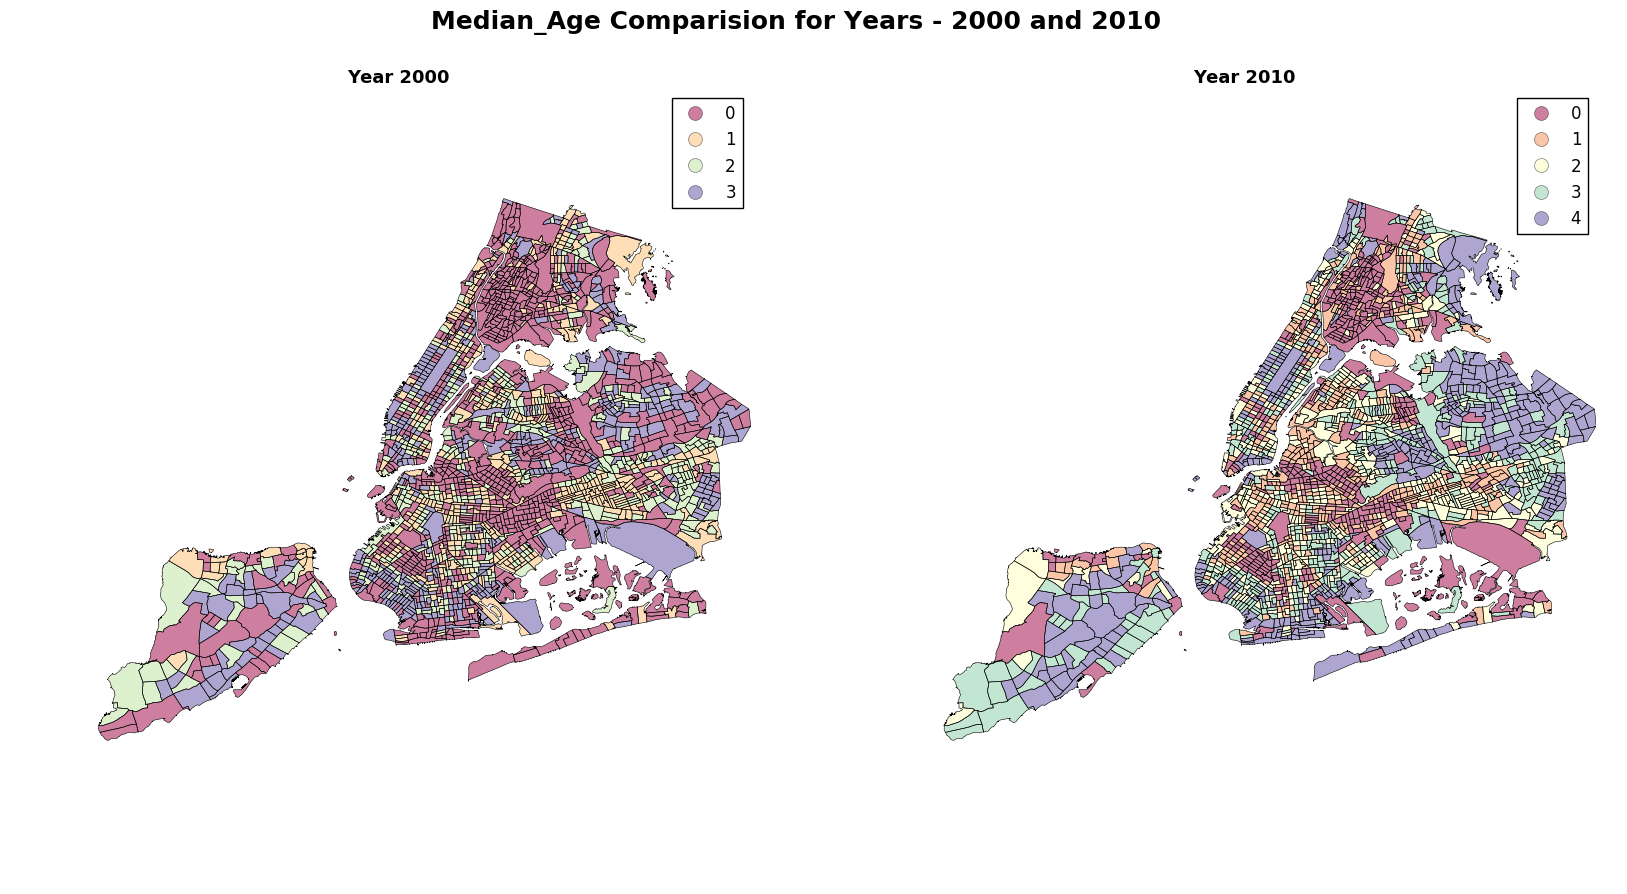

In [79]:
choropleth_function(merged_2000, merged_2010, qm2000Age, qm2010Age, 'Median_Age')

#### Figure-14: This figure represents the Median_Age Comparision between the years 2000 (left) and 2010 (right)

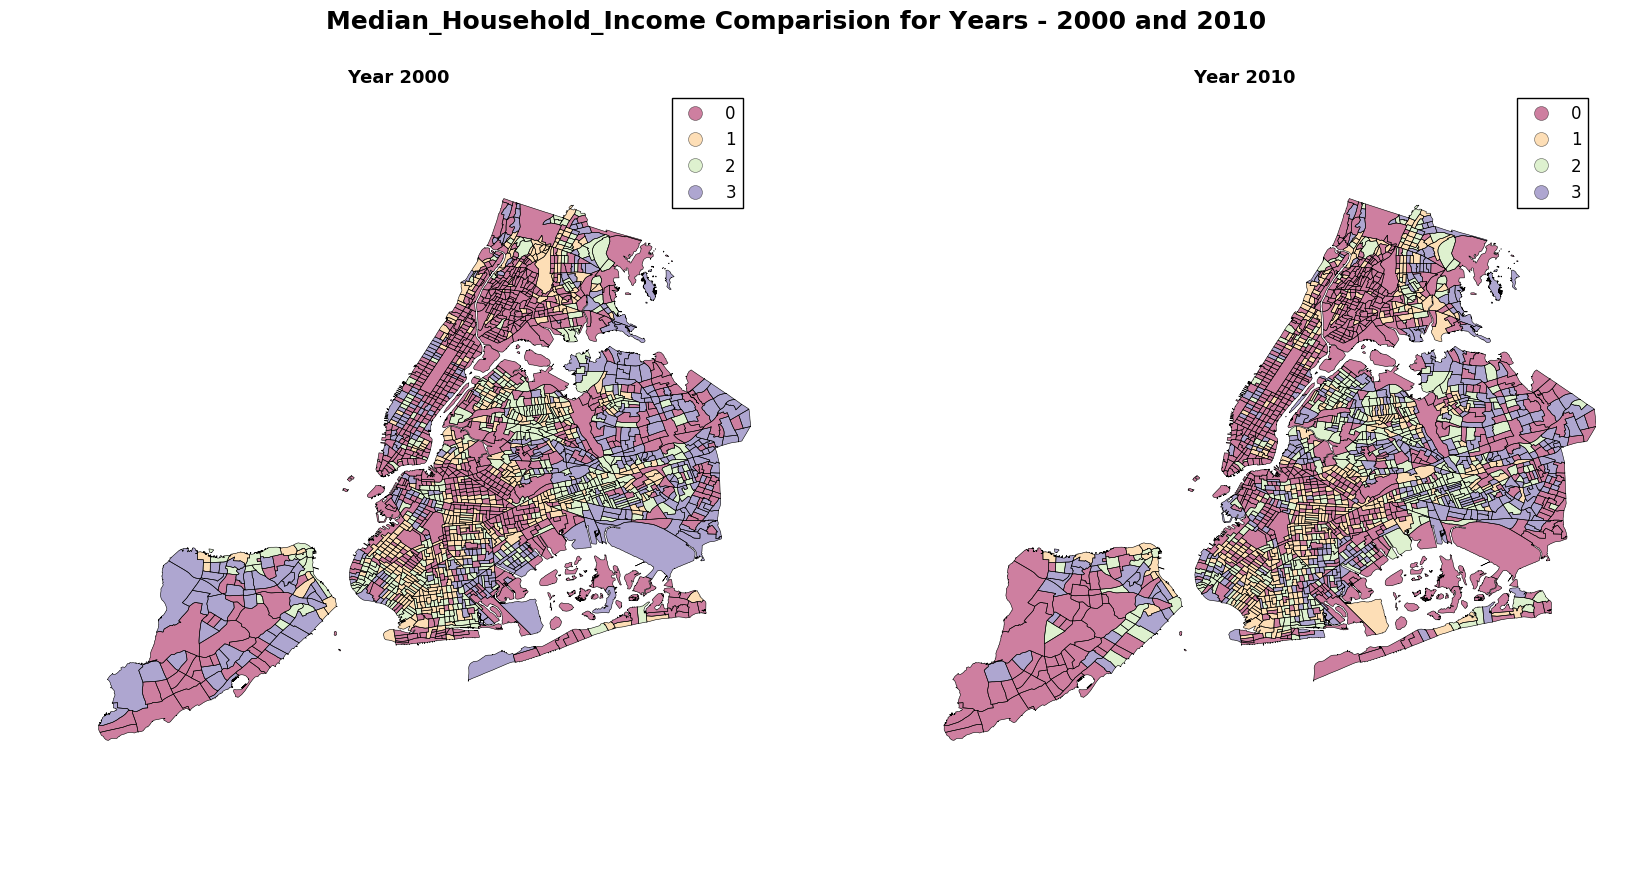

In [81]:
choropleth_function(merged_2000, merged_2010, qm2000Income, qm2010Income, 'Median_Household_Income')

#### Figure-15: This figure represents the Median_Household_Income Comparision between the years 2000 (left) and 2010 (right)

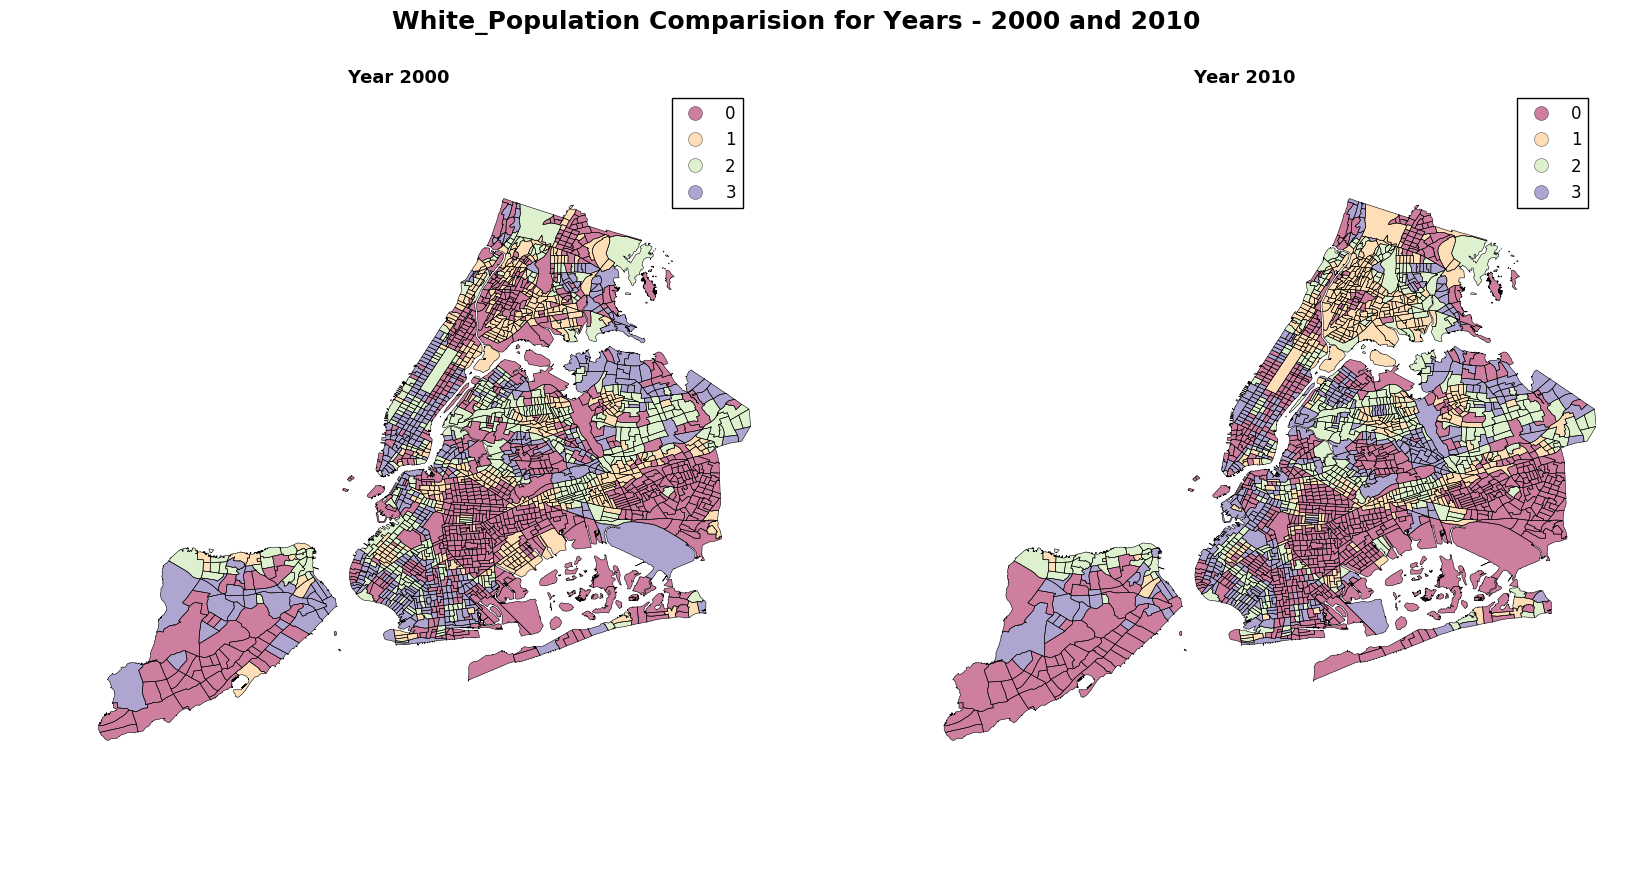

In [82]:
choropleth_function(merged_2000, merged_2010, qm2000White, qm2010White, 'White_Population')

#### Figure-16: This figure represents the White_Population_Percentage Comparision between the years 2000 (left) and 2010 (right)

In [245]:
merged_2010.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  
0            6250.0        32.7               15.5           40188.0  
1            4180.0        35.6                9.1           52958.0  
2            5017.0        33.3               29.5           45625.0  
3            6507.0        51.1               85.5           84350.0  
4            4949.0        32.4               63.5          117750.0

### Showing the difference in the features as a third choropleth using the 2010 data.

#### Calculating the differences in the Quantiles and Adding it as a seperate column in the Census file itself first.
- Here we use the Census - 2010 merged file to add the columns in.
- Using this due to the fact that the 2010 data is more complete and in order.

In [246]:
def difference_function (name, quantile_1, quantile_2):
    '''
    This function creates the difference to be observed
    between the years 2000 and 2010.
    This difference is achieved by equating the quantiles
    for the difference factor to be calculated.
    
    The parameters are defined below-
    
    name: The name that will be added as the column_title
    quantile_1: The first quantile to be equated(2010)
    quantile_2: The second quantile to be equated(2000)
    '''
    merged_2010[name] = (quantile_1.yb == quantile_2.yb)
    return merged_2010.head()

In [247]:
difference_function('Difference_Populace', qm2010Pop, qm2000Pop)

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  \
0            6250.0        32.7               15.5           40188.0   
1            4180.0        35.6                9.1           52958.0   
2            5017.0        33.3               29.5           45625.0   
3            6507.0        51.1               85.5           84350.0   
4            4949.0        32.4               63.5          117750.0   

  Difference_Populace  
0               False  
1                True  
2                True  
3               False  
4               False

In [248]:
difference_function('Difference_Age', qm2010Age, qm2000Age)

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  \
0            6250.0        32.7               15.5           40188.0   
1            4180.0        35.6                9.1           52958.0   
2            5017.0        33.3               29.5           45625.0   
3            6507.0        51.1               85.5           84350.0   
4            4949.0        32.4               63.5          117750.0   

  Difference_Populace Difference_Age  
0               False          False  
1                True           True  
2                True           True  
3               False          False  
4               False          False

In [249]:
difference_function('Difference_White_Pop', qm2010White, qm2000White)

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  \
0            6250.0        32.7               15.5           40188.0   
1            4180.0        35.6                9.1           52958.0   
2            5017.0        33.3               29.5           45625.0   
3            6507.0        51.1               85.5           84350.0   
4            4949.0        32.4               63.5          117750.0   

  Difference_Populace Difference_Age Difference_White_Pop  
0               False          False                False  
1                True           True                 True  
2                True           True                False  
3               False          False                False  
4               False          False                False

In [250]:
difference_function('Difference_Income', qm2010Income, qm2000Income)

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  \
0            6250.0        32.7               15.5           40188.0   
1            4180.0        35.6                9.1           52958.0   
2            5017.0        33.3               29.5           45625.0   
3            6507.0        51.1               85.5           84350.0   
4            4949.0        32.4               63.5          117750.0   

  Difference_Populace Difference_Age Difference_White_Pop Difference_Income  
0               False          False                False             False  
1                True           True                 True             False  
2                True           True                False              True  
3               False          False                False             False  
4               False          False                False              True

#### Creating a function to plot the differences in the data by using the differences in the quantiles itself.

In [89]:
def choropleth_difference_function (diff_column, name):
    '''
    This function creates a choropleth graph for 
    difference_factor in a DataFrame.
    
    The parameters are defined below-
    
    diff_column: The difference_factor being looked at 
    name: The plot title
    '''
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    
    merged_2010.plot(column = diff_column, categorical=True, k=10, 
                     cmap='jet_r',ax=ax, linewidth=0.4, edgecolor='black', legend=True)
    
    ax.set_axis_off()
    ax.set_title(name + ' ' + "Differences - 2000 v/s 2010", 
                 fontweight = 'bold', fontsize = '13')

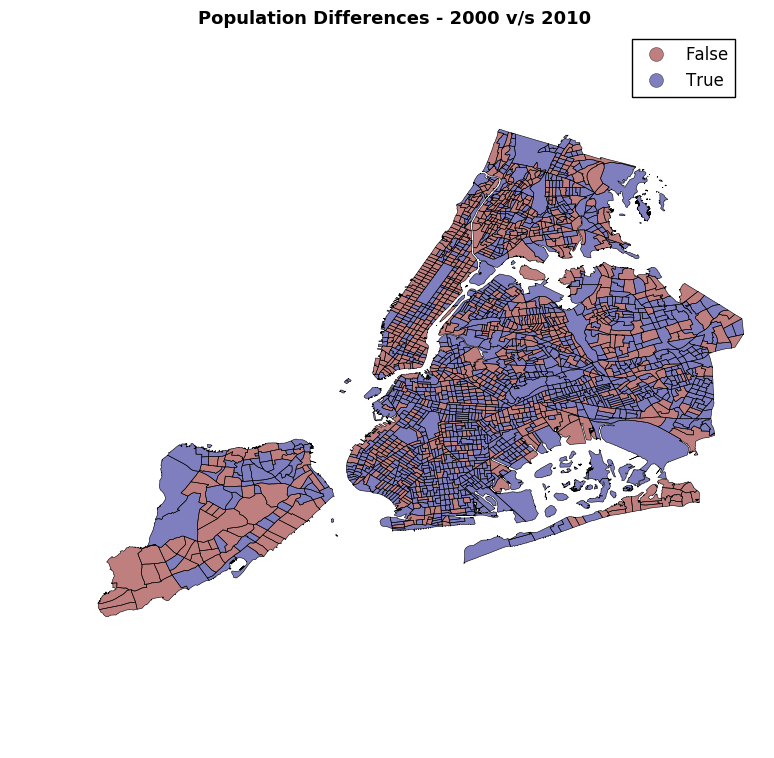

In [90]:
choropleth_difference_function('Difference_Populace', 'Population')

#### Figure-17: This figure represents the difference in population, through the years 2010 from 2000
- It can be observed here that, the reddish areas imply that there has been a change in the population from 2000 to 2010.
- The purple areas are areas that have shown no reported increase in this factor through the years.

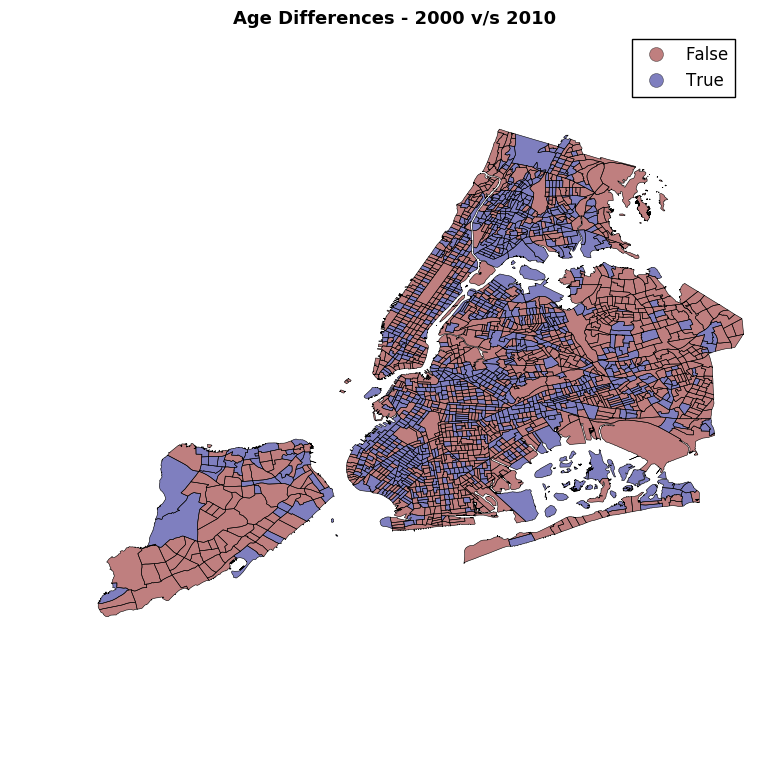

In [91]:
choropleth_difference_function('Difference_Age', 'Age')

#### Figure-18: This figure represents the difference in median age, through the years 2010 from 2000
- It can be observed here that, the reddish areas imply that there has been a change in the median_age from 2000 to 2010.
- The purple areas are areas that have shown no reported increase in this factor through the years.

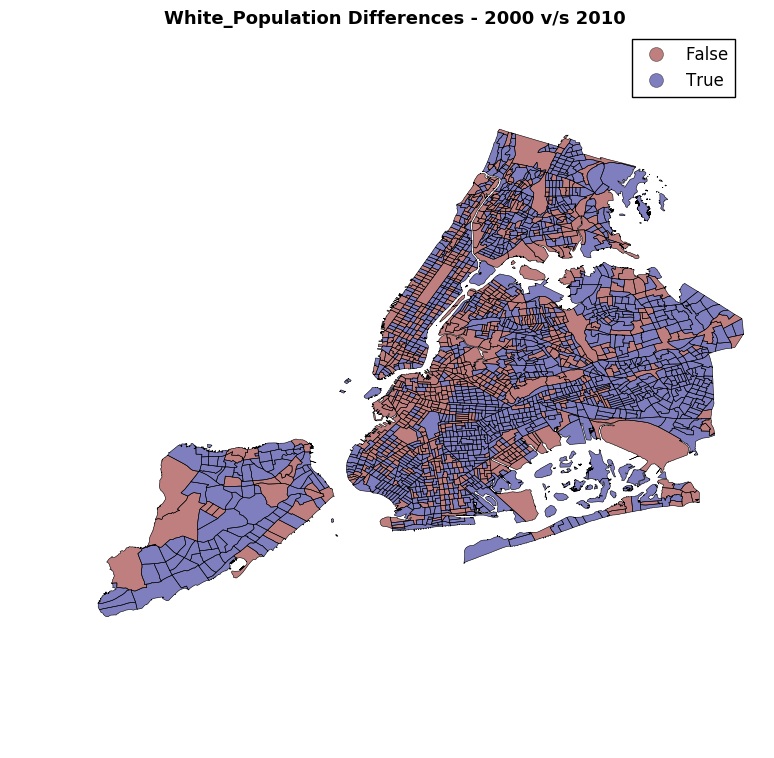

In [92]:
choropleth_difference_function('Difference_White_Pop', 'White_Population')

#### Figure-19: This figure represents the difference in percentage of white population, through the years 2010 from 2000
- It can be observed here that, the reddish areas imply that there has been a change in the percentage of white population from 2000 to 2010.
- The purple areas are areas that have shown no reported increase in this factor through the years.

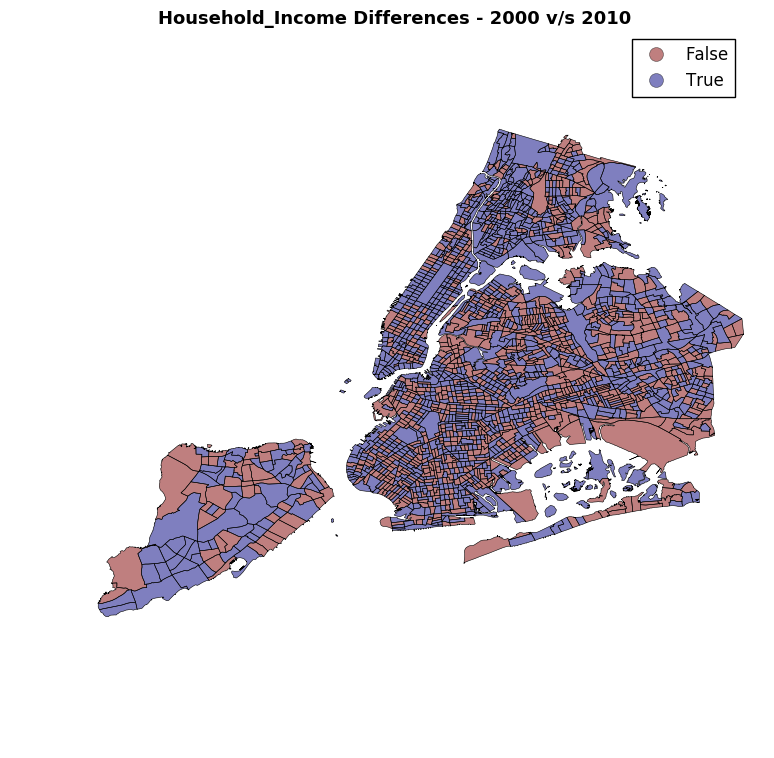

In [93]:
choropleth_difference_function('Difference_Income', 'Household_Income')

#### Figure-20: This figure represents the difference in median household incomes, through the years 2010 from 2000
- It can be observed here that, the reddish areas imply that there has been a change in the income from 2000 to 2010.
- The purple areas are areas that have shown no reported increase in this factor through the years.

### This aspect is an optional outlook to enable more insightful comments about the data and methods used.

In [251]:
merged_2000.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  
0               NaN         NaN                NaN               NaN  
1            4171.0        33.9                1.5           30241.0  
2            4877.0        31.7               30.1           36589.0  
3            6659.0        47.1               87.7           62341.0  
4            1370.0        41.3               55.4           85898.0

In [252]:
merged_2000 = merged_2000.rename(columns={'geometry':'geometry_2000', 
                                          'Total_Pop_Number':'Total_Pop_Number_2000', 
                                          'Median_Age':'Median_Age_2000', 
                                          'White_Pop_Percent':'White_Pop_Percent_2000', 
                                          'Median_HH_Income':'Median_HH_Income_2000'})
merged_2000.head()

geometry_2000                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number_2000  Median_Age_2000  White_Pop_Percent_2000  \
0                    NaN              NaN                     NaN   
1                 4171.0             33.9                     1.5   
2                 4877.0             31.7                    30.1   
3                 6659.0             47.1                    87.7   
4                 1370.0             41.3                    55.4   

   Median_HH_Income_2000  
0                    NaN  
1                30241.0  
2                36589.0  
3                62341.0  
4                85898.0

In [253]:
merged_2010.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number  Median_Age  White_Pop_Percent  Median_HH_Income  \
0            6250.0        32.7               15.5           40188.0   
1            4180.0        35.6                9.1           52958.0   
2            5017.0        33.3               29.5           45625.0   
3            6507.0        51.1               85.5           84350.0   
4            4949.0        32.4               63.5          117750.0   

  Difference_Populace Difference_Age Difference_White_Pop Difference_Income  
0               False          False                False             False  
1                True           True                 True             False  
2                True           True                False              True  
3               False          False                False             False  
4               False          False                False              True

In [254]:
merged_2010 = merged_2010.rename(columns={'geometry':'geometry_2010', 
                                          'Total_Pop_Number':'Total_Pop_Number_2010', 
                                          'Median_Age':'Median_Age_2010', 
                                          'White_Pop_Percent':'White_Pop_Percent_2010', 
                                          'Median_HH_Income':'Median_HH_Income_2010'})
merged_2010.head()

geometry_2010                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
0                 6250.0             32.7                    15.5   
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
0                40188.0               False          False   
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   

  Difference_White_Pop Difference_Income  
0                False             False  
1                 True             False  
2                False              True  
3                False             False  
4                False              True

In [255]:
merged_new = pd.merge(merged_2010, merged_2000, on = 'geo_id', how = 'inner')

In [256]:
merged_new = merged_new.drop(['geometry_2000'], axis = 1)
merged_new = merged_new.rename(columns={'geometry_2010':'geometry'})
merged_new.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
0                 6250.0             32.7                    15.5   
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
0                40188.0               False          False   
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
0                False             False                    NaN   
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  
0              NaN                     NaN                    NaN  
1             33.9                     1.5                30241.0  
2             31.7                    30.1                36589.0  
3             47.1                    87.7                62341.0  
4             41.3                    55.4                85898.0

In [257]:
merged_new = merged_new.dropna()
print (merged_new.shape)
merged_new.head()

(1880, 14)


geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   
5                39861.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   
5                False             False                 1564.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  
1             33.9                     1.5                30241.0  
2             31.7                    30.1                36589.0  
3             47.1                    87.7                62341.0  
4             41.3                    55.4                85898.0  
5             36.2                    10.4                10500.0

#### Clustering

In [258]:
merged_new.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   
5                39861.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   
5                False             False                 1564.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  
1             33.9                     1.5                30241.0  
2             31.7                    30.1                36589.0  
3             47.1                    87.7                62341.0  
4             41.3                    55.4                85898.0  
5             36.2                    10.4                10500.0

#### Seperating the Year - 2000 Data and Clustering it.

In [259]:
data_2000 = merged_new[['geo_id', 'Total_Pop_Number_2000', 'Median_Age_2000', 
                        'White_Pop_Percent_2000', 'Median_HH_Income_2000']]
data_2000.head()

geo_id  Total_Pop_Number_2000  Median_Age_2000  \
1  1400000US36047027500                 4171.0             33.9   
2  1400000US36005009200                 4877.0             31.7   
3  1400000US36081099100                 6659.0             47.1   
4  1400000US36081000100                 1370.0             41.3   
5  1400000US36047024100                 1564.0             36.2   

   White_Pop_Percent_2000  Median_HH_Income_2000  
1                     1.5                30241.0  
2                    30.1                36589.0  
3                    87.7                62341.0  
4                    55.4                85898.0  
5                    10.4                10500.0

#### Whitening the Data for the Year - 2000

In [260]:
data_2000['Total_Pop_Number_2000'] = data_2000['Total_Pop_Number_2000'] / data_2000['Total_Pop_Number_2000'].std()
data_2000['Median_Age__2000'] = data_2000['Median_Age_2000'] / data_2000['Median_Age_2000'].std()
data_2000['White_Pop_Percent_2000'] = data_2000['White_Pop_Percent_2000'] / data_2000['White_Pop_Percent_2000'].std()
data_2000['Median_HH_Income_2000'] = data_2000['Median_HH_Income_2000'] / data_2000['Median_HH_Income_2000'].std()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [261]:
data_2000.head()

geo_id  Total_Pop_Number_2000  Median_Age_2000  \
1  1400000US36047027500               1.928208             33.9   
2  1400000US36005009200               2.254585             31.7   
3  1400000US36081099100               3.078384             47.1   
4  1400000US36081000100               0.633336             41.3   
5  1400000US36047024100               0.723020             36.2   

   White_Pop_Percent_2000  Median_HH_Income_2000  Median_Age__2000  
1                0.048599               1.602551          5.903114  
2                0.975217               1.938949          5.520021  
3                2.841413               3.303616          8.201672  
4                1.794918               4.551965          7.191700  
5                0.336952               0.556423          6.303621

#### Creating the Clusters using k-means for the Year - 2000

In [262]:
columns_00 = ['Total_Pop_Number_2000', 'Median_Age_2000', 
              'White_Pop_Percent_2000', 'Median_HH_Income_2000']

In [263]:
kmeans_2000 = KMeans(5, random_state = 5762).fit(data_2000[columns_00])

In [264]:
kmeans_2000.labels_

array([4, 4, 1, ..., 4, 4, 0], dtype=int32)

In [265]:
merged_new['Cluster_Labels_2000'] = kmeans_2000.labels_

In [266]:
merged_new.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   
5                39861.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   
5                False             False                 1564.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  \
1             33.9                     1.5                30241.0   
2             31.7                    30.1                36589.0   
3             47.1                    87.7                62341.0   
4             41.3                    55.4                85898.0   
5             36.2                    10.4                10500.0   

   Cluster_Labels_2000  
1                    4  
2                    4  
3                    1  
4                    1  
5                    2

#### Seperating the Year - 2000 Data and Clustering it.

In [267]:
data_2010 = merged_new[['geo_id', 'Total_Pop_Number_2010', 'Median_Age_2010', 
                        'White_Pop_Percent_2010', 'Median_HH_Income_2010']]
data_2010.head()

geo_id  Total_Pop_Number_2010  Median_Age_2010  \
1  1400000US36047027500                 4180.0             35.6   
2  1400000US36005009200                 5017.0             33.3   
3  1400000US36081099100                 6507.0             51.1   
4  1400000US36081000100                 4949.0             32.4   
5  1400000US36047024100                 2229.0             31.3   

   White_Pop_Percent_2010  Median_HH_Income_2010  
1                     9.1                52958.0  
2                    29.5                45625.0  
3                    85.5                84350.0  
4                    63.5               117750.0  
5                    43.7                39861.0

#### Whitening the Data for the Year - 2010

In [268]:
data_2010['Total_Pop_Number_2010'] = data_2010['Total_Pop_Number_2010'] / data_2010['Total_Pop_Number_2010'].std()
data_2010['Median_Age_2010'] = data_2010['Median_Age_2010'] / data_2010['Median_Age_2010'].std()
data_2010['White_Pop_Percent_2010'] = data_2010['White_Pop_Percent_2010'] / data_2010['White_Pop_Percent_2010'].std()
data_2010['Median_HH_Income_2010'] = data_2010['Median_HH_Income_2010'] / data_2010['Median_HH_Income_2010'].std()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [269]:
data_2010.head()

geo_id  Total_Pop_Number_2010  Median_Age_2010  \
1  1400000US36047027500               1.952279         6.048035   
2  1400000US36005009200               2.343201         5.657291   
3  1400000US36081099100               3.039109         8.681309   
4  1400000US36081000100               2.311442         5.504392   
5  1400000US36047024100               1.041060         5.317514   

   White_Pop_Percent_2010  Median_HH_Income_2010  
1                0.309757               2.044274  
2                1.004156               1.761207  
3                2.910351               3.256061  
4                2.161489               4.545361  
5                1.487513               1.538706

#### Creating the Clusters using k-means for the Year - 2010 using the Cluster Centroids from the Clusters formed for the year - 2000

In [270]:
merged_new.shape

(1880, 15)

In [271]:
columns_10 = ['Total_Pop_Number_2010', 'Median_Age_2010', 
              'White_Pop_Percent_2010', 'Median_HH_Income_2010']

In [272]:
kmeans_2010 = KMeans(5,init = kmeans_2000.cluster_centers_).fit(data_2010[columns_10])

In [273]:
merged_new['Cluster_Labels_2010'] = kmeans_2010.labels_

In [274]:
merged_new.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   
5                39861.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   
5                False             False                 1564.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  \
1             33.9                     1.5                30241.0   
2             31.7                    30.1                36589.0   
3             47.1                    87.7                62341.0   
4             41.3                    55.4                85898.0   
5             36.2                    10.4                10500.0   

   Cluster_Labels_2000  Cluster_Labels_2010  
1                    4                    4  
2                    4                    1  
3                    1                    0  
4                    1                    0  
5                    2                    2

#### Plotting the Choropleth for the Clusters formed during the year - 2000 and 2010

#### Choropleths for the Years - 2000 and 2010

Using the Quantiles Function defined earlier in this notebook

In [275]:
clusters_2000 = quantiles_function(merged_new, 'Cluster_Labels_2000', 5)
clusters_2000

               Quantiles               
 
Lower          Upper              Count
        x[i] <= 1.000               620
1.000 < x[i] <= 2.000               597
2.000 < x[i] <= 4.000               663

In [276]:
clusters_2010 = quantiles_function(merged_new, 'Cluster_Labels_2010', 5)
clusters_2010

               Quantiles               
 
Lower          Upper              Count
        x[i] <= 1.000               611
1.000 < x[i] <= 2.000               425
2.000 < x[i] <= 3.000               294
3.000 < x[i] <= 4.000               550

In [277]:
Cluster_Choropleth_2000 = merged_new[['geometry', 'geo_id', 'Total_Pop_Number_2000', 'Median_Age_2000', 
                                      'White_Pop_Percent_2000', 'Median_HH_Income_2000', 
                                      'Cluster_Labels_2000']]
Cluster_Choropleth_2000.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2000  Median_Age_2000  White_Pop_Percent_2000  \
1                 4171.0             33.9                     1.5   
2                 4877.0             31.7                    30.1   
3                 6659.0             47.1                    87.7   
4                 1370.0             41.3                    55.4   
5                 1564.0             36.2                    10.4   

   Median_HH_Income_2000  Cluster_Labels_2000  
1                30241.0                    4  
2                36589.0                    4  
3                62341.0                    1  
4                85898.0                    1  
5                10500.0                    2

In [278]:
Cluster_Choropleth_2010 = merged_new[['geometry', 'geo_id', 'Total_Pop_Number_2010', 'Median_Age_2010', 
                                      'White_Pop_Percent_2010', 'Median_HH_Income_2010', 
                                      'Cluster_Labels_2000']]
Cluster_Choropleth_2010.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010  Cluster_Labels_2000  
1                52958.0                    4  
2                45625.0                    4  
3                84350.0                    1  
4               117750.0                    1  
5                39861.0                    2

#### Using the Choropleth Function defined earlier in this notebook

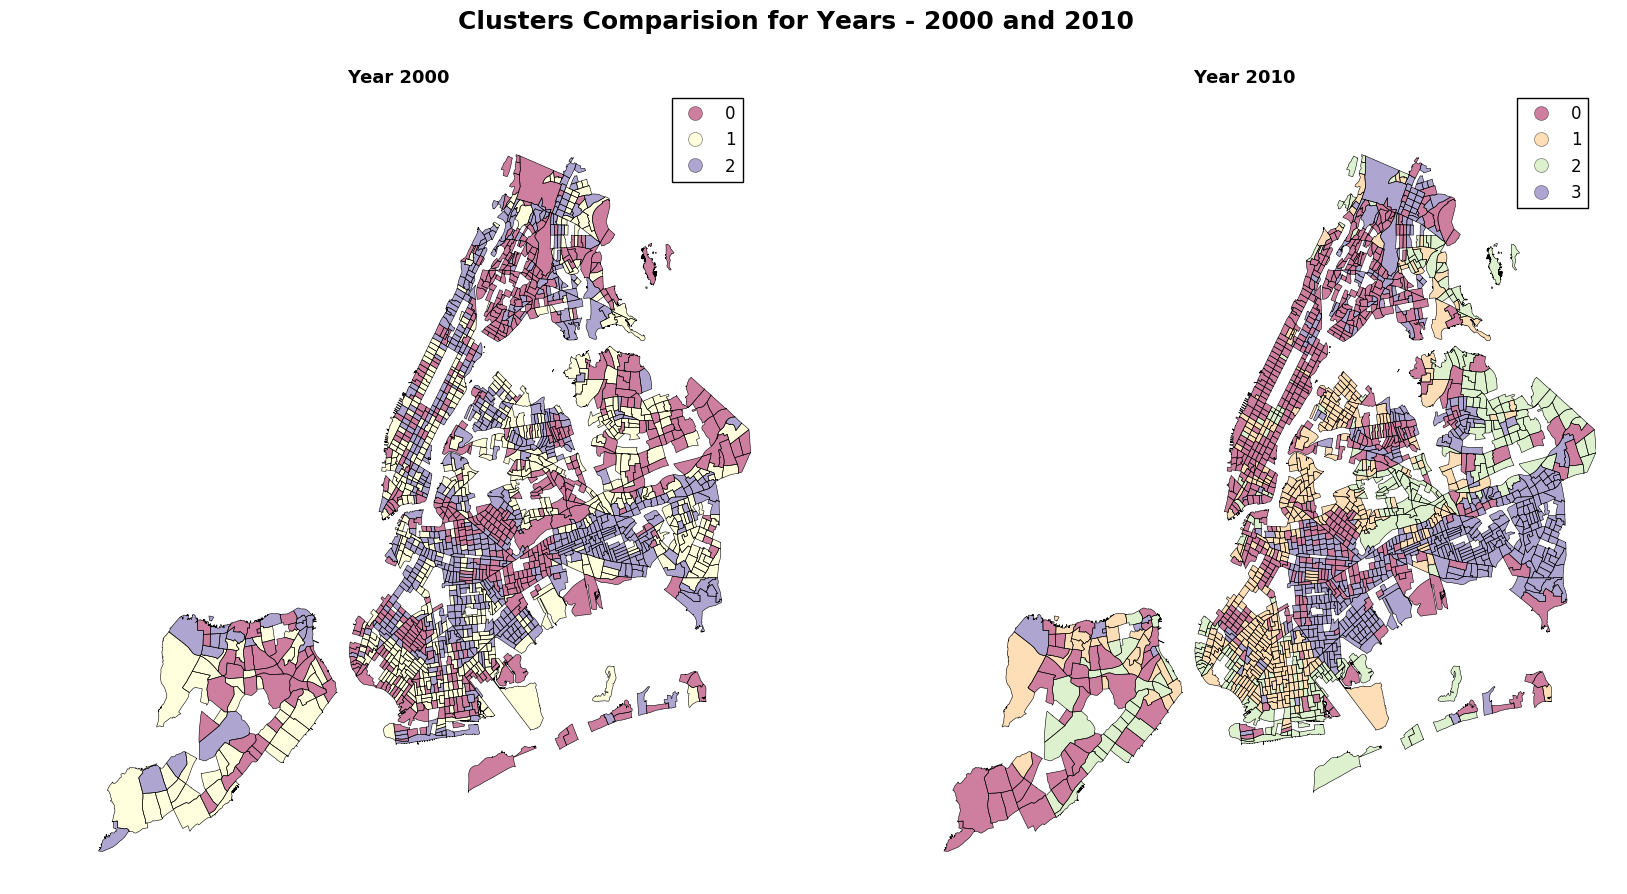

In [193]:
choropleth_function(Cluster_Choropleth_2000, Cluster_Choropleth_2010, clusters_2000, clusters_2010, 'Clusters')

#### Figure-21:

#### Choropleth - Clusters Difference

In [279]:
merged_new['Cluster_Differences'] = (clusters_2000.yb == clusters_2010.yb)
merged_new.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   
5                39861.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   
5                False             False                 1564.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  \
1             33.9                     1.5                30241.0   
2             31.7                    30.1                36589.0   
3             47.1                    87.7                62341.0   
4             41.3                    55.4                85898.0   
5             36.2                    10.4                10500.0   

   Cluster_Labels_2000  Cluster_Labels_2010 Cluster_Differences  
1                    4                    4               False  
2                    4                    1               False  
3                    1                    0                True  
4                    1                    0                True  
5                    2                    2                True

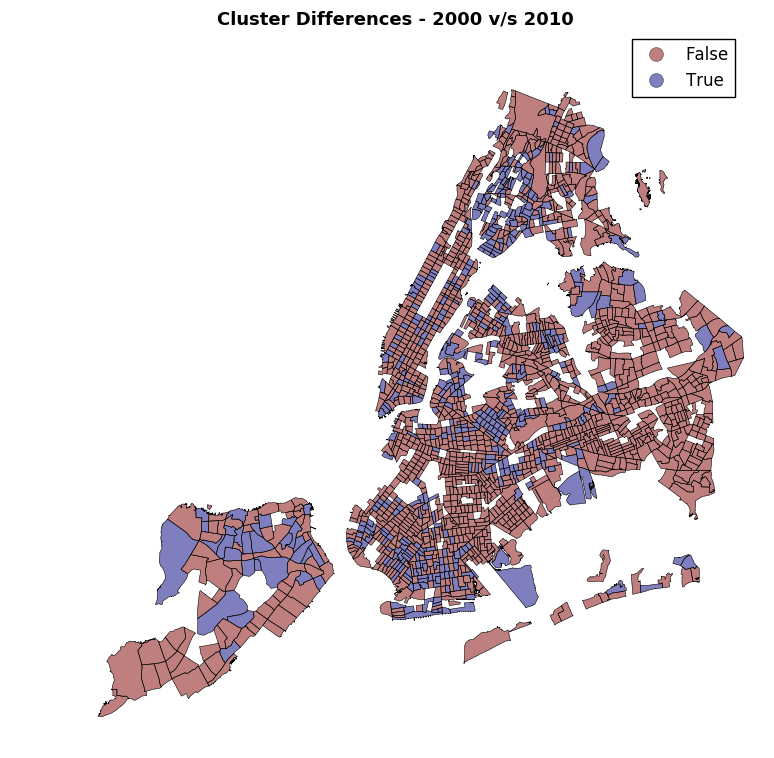

In [195]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
    
merged_new.plot(column = 'Cluster_Differences', categorical=True, k=10, 
                cmap='jet_r',ax=ax, linewidth=0.4, edgecolor='black', legend=True)
    
ax.set_axis_off()
ax.set_title("Cluster Differences - 2000 v/s 2010", fontweight = 'bold', fontsize = '13')

#### Figure-22: 

### Aggregating the Census Four Features at the Zipcode level and merging the Zipcode Dataframe

In [280]:
merged_new.crs = from_epsg(4326)

In [281]:
merged_new['Center_Geometry'] = merged_new.geometry.centroid
merged_new.head()

geometry                geo_id  \
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
5  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_Pop_Number_2010  Median_Age_2010  White_Pop_Percent_2010  \
1                 4180.0             35.6                     9.1   
2                 5017.0             33.3                    29.5   
3                 6507.0             51.1                    85.5   
4                 4949.0             32.4                    63.5   
5                 2229.0             31.3                    43.7   

   Median_HH_Income_2010 Difference_Populace Difference_Age  \
1                52958.0                True           True   
2                45625.0                True           True   
3                84350.0               False          False   
4               117750.0               False          False   
5                39861.0               False          False   

  Difference_White_Pop Difference_Income  Total_Pop_Number_2000  \
1                 True             False                 4171.0   
2                False              True                 4877.0   
3                False             False                 6659.0   
4                False              True                 1370.0   
5                False             False                 1564.0   

   Median_Age_2000  White_Pop_Percent_2000  Median_HH_Income_2000  \
1             33.9                     1.5                30241.0   
2             31.7                    30.1                36589.0   
3             47.1                    87.7                62341.0   
4             41.3                    55.4                85898.0   
5             36.2                    10.4                10500.0   

   Cluster_Labels_2000  Cluster_Labels_2010 Cluster_Differences  \
1                    4                    4               False   
2                    4                    1               False   
3                    1                    0                True   
4                    1                    0                True   
5                    2                    2                True   

                                Center_Geometry  
1  POINT (-73.93817849385184 40.68389708695573)  
2  POINT (-73.85210982299243 40.83235742729679)  
3  POINT (-73.80002157849106 40.79030242380239)  
4  POINT (-73.95065299870262 40.74321286156224)  
5  POINT (-73.95380379679214 40.69222179804105)

In [282]:
merged_new_format = merged_new[['geo_id', 'Total_Pop_Number_2000', 'Total_Pop_Number_2010', 
                                'Median_Age_2000', 'Median_Age_2010', 
                                'White_Pop_Percent_2000', 'White_Pop_Percent_2010', 
                                'Median_HH_Income_2000', 'Median_HH_Income_2010', 
                                'Cluster_Labels_2000', 'Cluster_Labels_2010', 
                                'Difference_Populace', 'Difference_Age', 
                                'Difference_White_Pop', 'Difference_Income', 
                                'Cluster_Differences', 'Center_Geometry']]
merged_new_format = merged_new_format.rename(columns={'Center_Geometry':'geometry'})
merged_new_format.head()

geo_id  Total_Pop_Number_2000  Total_Pop_Number_2010  \
1  1400000US36047027500                 4171.0                 4180.0   
2  1400000US36005009200                 4877.0                 5017.0   
3  1400000US36081099100                 6659.0                 6507.0   
4  1400000US36081000100                 1370.0                 4949.0   
5  1400000US36047024100                 1564.0                 2229.0   

   Median_Age_2000  Median_Age_2010  White_Pop_Percent_2000  \
1             33.9             35.6                     1.5   
2             31.7             33.3                    30.1   
3             47.1             51.1                    87.7   
4             41.3             32.4                    55.4   
5             36.2             31.3                    10.4   

   White_Pop_Percent_2010  Median_HH_Income_2000  Median_HH_Income_2010  \
1                     9.1                30241.0                52958.0   
2                    29.5                36589.0                45625.0   
3                    85.5                62341.0                84350.0   
4                    63.5                85898.0               117750.0   
5                    43.7                10500.0                39861.0   

   Cluster_Labels_2000  Cluster_Labels_2010 Difference_Populace  \
1                    4                    4                True   
2                    4                    1                True   
3                    1                    0               False   
4                    1                    0               False   
5                    2                    2               False   

  Difference_Age Difference_White_Pop Difference_Income Cluster_Differences  \
1           True                 True             False               False   
2           True                False              True               False   
3          False                False             False                True   
4          False                False              True                True   
5          False                False             False                True   

                                       geometry  
1  POINT (-73.93817849385184 40.68389708695573)  
2  POINT (-73.85210982299243 40.83235742729679)  
3  POINT (-73.80002157849106 40.79030242380239)  
4  POINT (-73.95065299870262 40.74321286156224)  
5  POINT (-73.95380379679214 40.69222179804105)

In [283]:
merged_new_format.crs = from_epsg(4326)

In [284]:
zip_codes_shape_crs = zip_codes_shape.to_crs(epsg=4326)
zip_codes_shape_crs.head()

Shape_Area                                           geometry  zip_code  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096788...     11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...     11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...     11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...     11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...     11365   

   2000  2010  Calculated_Area  Density_2000  Density_2010 Density_Difference  
0  1409  1629         0.000200    704.586533    814.600044               True  
1   189   229         0.000224     84.330384    102.178084               True  
2  1350  1494         0.000062   2176.227439   2408.358366               True  
3   213   248         0.000489     43.542923     50.697864               True  
4   553   643         0.000688     80.416343     93.503994              False

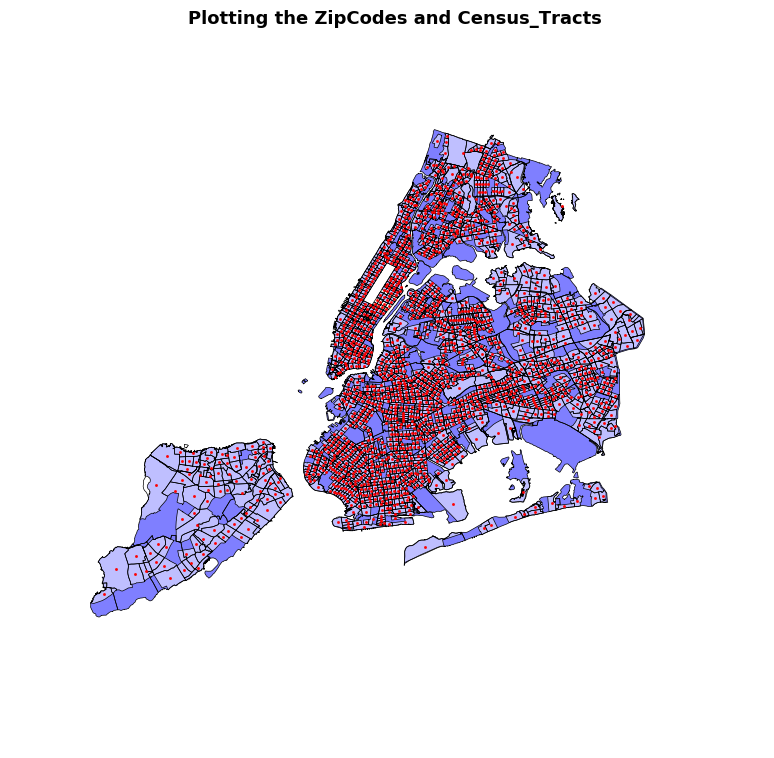

In [285]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

zip_codes_shape_crs.plot(ax=ax, color='blue', linewidth = 0.5)
merged_new.plot(ax=ax, color='white', linewidth = 0.5)
gpd.GeoDataFrame(merged_new_format).plot(ax=ax, marker='.', color='red', markersize=3)

ax.set_axis_off()
ax.set_title('Plotting the ZipCodes and Census_Tracts', fontsize = 13, fontweight = 'bold')

In [286]:
merged_zip_census = gpd.sjoin(merged_new_format, zip_codes_shape_crs)
merged_zip_census.head()

geo_id  Total_Pop_Number_2000  Total_Pop_Number_2010  \
1    1400000US36047027500                 4171.0                 4180.0   
41   1400000US36047037700                 3827.0                 3660.0   
42   1400000US36047037300                 4199.0                 3784.0   
235  1400000US36047036501                 2349.0                 2624.0   
444  1400000US36047027300                 3061.0                 2813.0   

     Median_Age_2000  Median_Age_2010  White_Pop_Percent_2000  \
1               33.9             35.6                     1.5   
41              32.7             34.2                     1.0   
42              30.2             32.7                     4.1   
235             33.1             35.7                     3.3   
444             31.9             35.7                     1.2   

     White_Pop_Percent_2010  Median_HH_Income_2000  Median_HH_Income_2010  \
1                       9.1                30241.0                52958.0   
41                      5.1                34601.0                46584.0   
42                      6.7                20912.0                27263.0   
235                     2.6                20948.0                35673.0   
444                     5.7                29883.0                40187.0   

     Cluster_Labels_2000         ...          \
1                      4         ...           
41                     4         ...           
42                     4         ...           
235                    4         ...           
444                    4         ...           

                                         geometry index_right    Shape_Area  \
1    POINT (-73.93817849385184 40.68389708695573)          27  3.787169e+07   
41   POINT (-73.92018756824383 40.68408835068919)          27  3.787169e+07   
42   POINT (-73.91521524702083 40.68394899172933)          27  3.787169e+07   
235   POINT (-73.91151946721243 40.6750173426112)          27  3.787169e+07   
444  POINT (-73.93743823216319 40.68108411868305)          27  3.787169e+07   

    zip_code 2000 2010 Calculated_Area  Density_2000  Density_2010  \
1      11233  261  364        0.000374     69.819962     97.373433   
41     11233  261  364        0.000374     69.819962     97.373433   
42     11233  261  364        0.000374     69.819962     97.373433   
235    11233  261  364        0.000374     69.819962     97.373433   
444    11233  261  364        0.000374     69.819962     97.373433   

     Density_Difference  
1                 False  
41                False  
42                False  
235               False  
444               False  

[5 rows x 26 columns]

In [287]:
merged_zip_census.columns

Index([                u'geo_id',  u'Total_Pop_Number_2000',
        u'Total_Pop_Number_2010',        u'Median_Age_2000',
              u'Median_Age_2010', u'White_Pop_Percent_2000',
       u'White_Pop_Percent_2010',  u'Median_HH_Income_2000',
        u'Median_HH_Income_2010',    u'Cluster_Labels_2000',
          u'Cluster_Labels_2010',    u'Difference_Populace',
               u'Difference_Age',   u'Difference_White_Pop',
            u'Difference_Income',    u'Cluster_Differences',
                     u'geometry',            u'index_right',
                   u'Shape_Area',               u'zip_code',
                         u'2000',                   u'2010',
              u'Calculated_Area',           u'Density_2000',
                 u'Density_2010',     u'Density_Difference'],
      dtype='object')

In [288]:
merged_zip_census = merged_zip_census.drop([u'Cluster_Labels_2000', u'Cluster_Labels_2010',
                                            u'Shape_Area', u'2000', u'2010', u'Calculated_Area'], axis = 1)
merged_zip_census.head(1)

geo_id  Total_Pop_Number_2000  Total_Pop_Number_2010  \
1  1400000US36047027500                 4171.0                 4180.0   

   Median_Age_2000  Median_Age_2010  White_Pop_Percent_2000  \
1             33.9             35.6                     1.5   

   White_Pop_Percent_2010  Median_HH_Income_2000  Median_HH_Income_2010  \
1                     9.1                30241.0                52958.0   

  Difference_Populace Difference_Age Difference_White_Pop Difference_Income  \
1                True           True                 True             False   

  Cluster_Differences                                      geometry  \
1               False  POINT (-73.93817849385184 40.68389708695573)   

   index_right  zip_code  Density_2000  Density_2010 Density_Difference  
1           27     11233     69.819962     97.373433              False

In [289]:
print(merged_zip_census.columns)

Index([u'geo_id', u'Total_Pop_Number_2000', u'Total_Pop_Number_2010',
       u'Median_Age_2000', u'Median_Age_2010', u'White_Pop_Percent_2000',
       u'White_Pop_Percent_2010', u'Median_HH_Income_2000',
       u'Median_HH_Income_2010', u'Difference_Populace', u'Difference_Age',
       u'Difference_White_Pop', u'Difference_Income', u'Cluster_Differences',
       u'geometry', u'index_right', u'zip_code', u'Density_2000',
       u'Density_2010', u'Density_Difference'],
      dtype='object')


In [290]:
aggregate_zip_census = merged_zip_census.groupby('zip_code').agg({'Total_Pop_Number_2000':'mean', 
                                                                  'Total_Pop_Number_2010':'mean',
                                                                  'Median_Age_2000':'mean',
                                                                  'Median_Age_2010':'mean',
                                                                  'White_Pop_Percent_2000':'mean',
                                                                  'White_Pop_Percent_2010':'mean',
                                                                  'Median_HH_Income_2000':'mean',
                                                                  'Median_HH_Income_2010':'mean',
                                                                  'Difference_Populace':'mean', 
                                                                  'Difference_Age':'mean',
                                                                  'Difference_White_Pop':'mean', 
                                                                  'Difference_Income':'mean',
                                                                  'Density_2000':'first',
                                                                  'Density_2010':'first',
                                                                  'Density_Difference':'first'}).reset_index()

In [291]:
aggregate_zip_census = gpd.GeoDataFrame(pd.merge(aggregate_zip_census , 
                                                 zip_codes_shape[['zip_code', 'geometry']], 
                                                 on= 'zip_code', how='inner'))
aggregate_zip_census.head()

zip_code  White_Pop_Percent_2010 Density_Difference  Density_2000  \
0     10001               63.550000               True   4145.613399   
1     10002               40.385714               True    874.466759   
2     10003               76.630000               True   2385.612309   
3     10004               79.100000               True   3294.548739   
4     10004               79.100000               True   3294.548739   

   Total_Pop_Number_2010  Total_Pop_Number_2000  Difference_Populace  \
0            2610.000000            2149.333333             0.666667   
1            5758.357143            6061.142857             0.428571   
2            5528.200000            5294.300000             0.400000   
3             731.000000            1111.000000             1.000000   
4             731.000000            1111.000000             1.000000   

   Difference_Age  White_Pop_Percent_2000  Difference_Income  Median_Age_2010  \
0        0.166667               63.566667           0.166667        34.633333   
1        0.214286               35.821429           0.428571        39.821429   
2        0.500000               77.980000           0.600000        32.670000   
3        0.000000               74.600000           1.000000        31.100000   
4        0.000000               74.600000           1.000000        31.100000   

   Density_2010  Median_Age_2000  Median_HH_Income_2000  Difference_White_Pop  \
0   4102.553864        37.000000           53814.666667              0.000000   
1   1102.972566        37.857143           25544.357143              0.428571   
2   2664.138861        33.970000           67424.400000              0.500000   
3   3559.334727        34.300000          105456.000000              0.000000   
4   3559.334727        34.300000          105456.000000              0.000000   

   Median_HH_Income_2010                                           geometry  
0           81678.666667  POLYGON ((-74.00827017711134 40.75258714368449...  
1           41051.357143  POLYGON ((-73.97441674489379 40.73642441865476...  
2           95601.400000  POLYGON ((-73.97986374196766 40.73497446573838...  
3          112083.000000  POLYGON ((-74.00596661578348 40.7043243225291,...  
4          112083.000000  POLYGON ((-74.04166368343016 40.69644987183209...

#### Defining a Choropleth_Function for plotting the Choropleth's for the Zipcode Aggregated Dataset

In [300]:
def choropleth_zipcode (dataframe, quantile_1, quantile_2, quantile_3, name):
    '''
    This function creates a choropleth graph for 
    different factors to be compared with each 
    other in the same DataFrame.
    
    The parameters are defined below-
    
    dataframe: The dataframe that is being observed 
    quantile_1: The 1st Quantile that is being looked into
    quantile_2: The 2nd Quantile that is being looked into
    quantile_3: The 2nd Quantile that is being looked into
    column_name: The column needed to be plot
    name: The title of the plot
    '''
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    dataframe.assign(cl=quantile_1.yb).plot(column='cl', categorical=True, 
                                            k=5, cmap='Spectral',ax=ax1, 
                                            linewidth=0.4, edgecolor='black', legend=True)
    
    ax1.set_axis_off()
    ax1.set_title("Year 2000", fontweight = 'bold', fontsize = '13')
    
    dataframe.assign(cl=quantile_2.yb).plot(column='cl', categorical=True, 
                                            k=5, cmap='Spectral',ax=ax2, 
                                            linewidth=0.4, edgecolor='black', legend=True)
    
    ax2.set_axis_off()
    ax2.set_title("Year 2010", fontweight = 'bold', fontsize = '13')
    
    dataframe.assign(cl=quantile_3.yb).plot(column='cl', categorical=True, 
                                            k=5, cmap='Spectral',ax=ax3, 
                                            linewidth=0.4, edgecolor='black', legend=True)
    
    ax3.set_axis_off()
    ax3.set_title("Difference", fontweight = 'bold', fontsize = '13')
    
    plt.suptitle(name + ' ' + "Comparision for Years - 2000 and 2010", 
                 fontweight = 'bold', fontsize = 18)

#### Median_Age - Calculation of the Quantiles and Plotting the Choropleth - Aggregated and by Zipcodes

In [292]:
age_2000 = quantiles_function(aggregate_zip_census, 'Median_Age_2000', 5)
age_2000

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 31.940               38
31.940 < x[i] <= 33.402               36
33.402 < x[i] <= 35.306               36
35.306 < x[i] <= 38.615               37
38.615 < x[i] <= 73.000               37

In [293]:
age_2010 = quantiles_function(aggregate_zip_census, 'Median_Age_2010', 5)
age_2010

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 32.747               37
32.747 < x[i] <= 34.830               37
34.830 < x[i] <= 37.134               36
37.134 < x[i] <= 40.292               38
40.292 < x[i] <= 80.900               36

In [294]:
age_diff = quantiles_function(aggregate_zip_census, 'Difference_Age', 5)
age_diff

              Quantiles               
 
Lower          Upper             Count
        x[i] <= 0.167               39
0.167 < x[i] <= 0.364               36
0.364 < x[i] <= 0.516               35
0.516 < x[i] <= 0.714               40
0.714 < x[i] <= 1.000               34

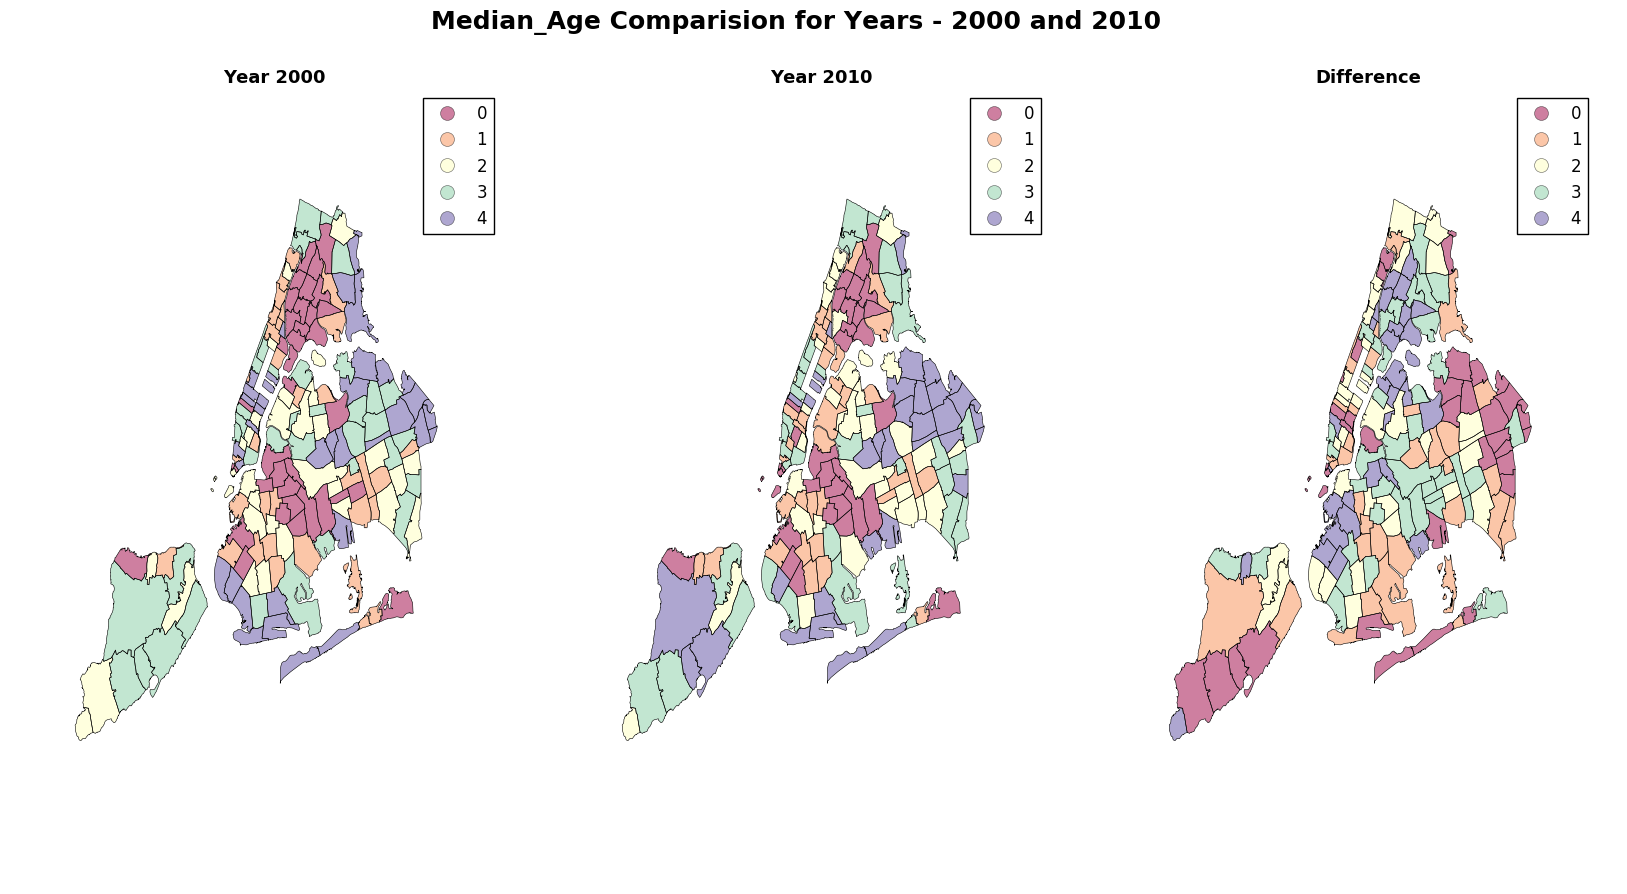

In [299]:
choropleth_zipcode(aggregate_zip_census, age_2000, age_2010, age_diff, 'Median_Age')

#### Median_Household_Income - Calculation of the Quantiles and Plotting the Choropleth - Aggregated and by Zipcodes

#### White_Population_Percentage - Calculation of the Quantiles and Plotting the Choropleth - Aggregated and by Zipcodes

#### Total_Population - Calculation of the Quantiles and Plotting the Choropleth - Aggregated and by Zipcodes

#### Business_Density - Calculation of the Quantiles and Plotting the Choropleth - Aggregated and by Zipcodes